# RTP Forecasting

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from scipy.stats import gaussian_kde


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
print(tf.__version__)

2.12.0


In [3]:
cwd = os.getcwd()

In [4]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [5]:
#timing callback
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

# Functions for various plots for comparisons

In [6]:
def plot_predictions_models(pred_1,pred_2,pred_3, actual, title, time, filename, year=False):
    plt.figure(figsize=(15, 3), dpi=150)
    plt.plot(np.arange(len(pred_1)), np.array(actual),label='PF', alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_1),label='LSTM',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_2),label='CNN',alpha=0.7)
    plt.plot(np.arange(len(pred_1)), np.array(pred_3),label='CNN-LSTM',alpha=0.7)
    plt.legend(loc='upper right')
    plt.xlabel(time ,  fontsize=12)
    plt.ylabel('Price ($/MWh)' , fontsize=12)
    if year == True:
        if int(len(pred_1)/12)-len(pred_1)/12 == 0:
            plt.xticks(np.arange(0, len(pred_1) + int(len(pred_1)/12+1), int(len(pred_1)/12)+1), [str(i) for i in range(0, 13)])
        else:
            plt.xticks(np.arange(0, len(pred_1), int(len(pred_1)/12)), [str(i) for i in range(0, 13)])
    else:
        plt.xticks(np.arange(0, len(pred_1)+24, 24), [str(i) for i in range(0, int(len(pred_1)/24)+1)])
    plt.margins(x=0)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.title(title, fontsize=12)
    plt.savefig("figures/"+filename+".pdf", format="pdf", bbox_inches="tight")

def plot_hourly_errors(pred_1,pred_2,pred_3, title, filename):
    plt.figure(figsize=(15, 3), dpi=150)
    plt.plot(np.arange(len(pred_1)), np.array(pred_1),label='LSTM', marker='o')
    plt.plot(np.arange(len(pred_1)), np.array(pred_2),label='CNN', marker='s')
    plt.plot(np.arange(len(pred_1)), np.array(pred_3),label='CNN-LSTM', marker='^')
    plt.legend()
    plt.xlabel('Time (hours)' ,  fontsize=12)
    plt.ylabel('MAE ($/MWh)' , fontsize=12)
    plt.xticks(range(len(pred_1)), [str(x + 1) for x in range(len(pred_1))])
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.title(title, fontsize=12)
    plt.savefig("figures/"+filename+".pdf", format="pdf", bbox_inches="tight")

def plot_profile(data, title, filename, y_label):
    plt.figure(figsize=(15, 5), dpi=150)
    plt.plot(np.arange(len(data)), data, linewidth=0.7)
    plt.xticks(np.arange(0, len(data)+730, 730), [str(i) for i in range(0, int(len(data)/730)+1)])
    plt.xlabel("Time (months)", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.title(title, fontsize=12)
    plt.savefig("figures/"+filename+".pdf", format="pdf", bbox_inches="tight")

def plot_profile_twin(data, data2, type, title, filename, y_label):
    plt.figure(figsize=(15, 5), dpi=150)
    line1, = plt.plot(np.arange(len(data)), data, linewidth=0.7, label='raw '+type)
    plt.xlabel("Time (months)", fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5) 
    plt2 = plt.gca().twinx()
    line2, = plt2.plot(np.arange(len(data)), data2, linewidth=0.7, color='orange', label='log '+type)
    plt2.set_ylabel(y_label, fontsize=12)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)  
    plt.xticks(np.arange(0, len(data) + 730, 730), [str(i) for i in range(0, int(len(data) / 730) + 1)])
    plt.title(title, fontsize=12)
    plt.legend([line1, line2], ['raw '+type, 'log '+type], loc='upper left')
    plt.savefig("figures/"+filename+".pdf", format="pdf", bbox_inches="tight")

def plot_distribution(data1, data2, type, filename):
    plt.figure(figsize=(15, 5), dpi=150) 
    plt.subplot(1, 2, 1)
    kde1 = gaussian_kde(data1)
    x_vals1 = np.linspace(min(data1), max(data1), 1000)
    y_vals1 = kde1(x_vals1)
    plt.plot(x_vals1, y_vals1, label='raw '+type)
    plt.xticks(ha='right')
    # plt.yticks(np.linspace(0, 0.03, 7))
    plt.xlabel("Price ($/MWh)")
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.legend()

    plt.subplot(1, 2, 2)
    kde2 = gaussian_kde(data2)
    x_vals2 = np.linspace(min(data2), max(data2), 1000)
    y_vals2 = kde2(x_vals2)
    plt.plot(x_vals2, y_vals2, label='log '+type)
    plt.xticks(ha='right')
    plt.xlabel("Price ($/MWh)")
    plt.ylabel("Density")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    # plt.yticks(np.linspace(0, 4.5, 7))
    plt.legend()
    plt.tight_layout()
    plt.savefig("figures/"+filename+".pdf", format="pdf", bbox_inches="tight")


In [7]:
zone = 'N.Y.C.'
year = 2021

### Data Import

In [8]:
# Read each timeseries (RTP = Real-Time Price, DAP = Day-Ahead Price, LF = Load Forecast)
raw_DAP = pd.read_csv("nyiso/da_lmp_zones_df_2015_2021.csv", index_col=0)
raw_RTP = pd.read_csv("nyiso/rt_lmp_zones_df_2015_2021.csv", index_col=0)
raw_LF = pd.read_csv("nyiso/load_frcstd_df_2015_2021.csv", index_col=0)

In [9]:
# Prepare the dataset as a dataframe
raw_data = pd.concat([raw_DAP.loc[:,zone], raw_LF.loc[:,zone], raw_RTP.loc[:,zone]],
                       axis=1).loc['2017-01-01 05:00:00+00:00':]
raw_data.columns = ['DAP', 'LF', 'RTP']
raw_data.index.names = ['date']
raw_data.to_csv('nyiso/NYISO_'+zone+'_raw.csv')

In [10]:
# We perform log tranformation before feeding the dataset into the model to make enhance the performance
# We only log tranform the price data (RTP and DAP)
log = 1
# log transformation for the forecasting task log10(Y + 1 - min(Y))
if log:
    log_data = raw_data.copy(deep=True)
    log_data.loc[:,"DAP"] = np.log(raw_data.loc[:,"DAP"] + 1 - min(raw_data.loc[:,"DAP"]))
    log_data.loc[:,"RTP"] = np.log(raw_data.loc[:,"RTP"] + 1 - min(raw_data.loc[:,"RTP"]))
    log_data.to_csv('nyiso/NYISO_'+zone+'_log.csv')

## Generating Explanatory Figures 

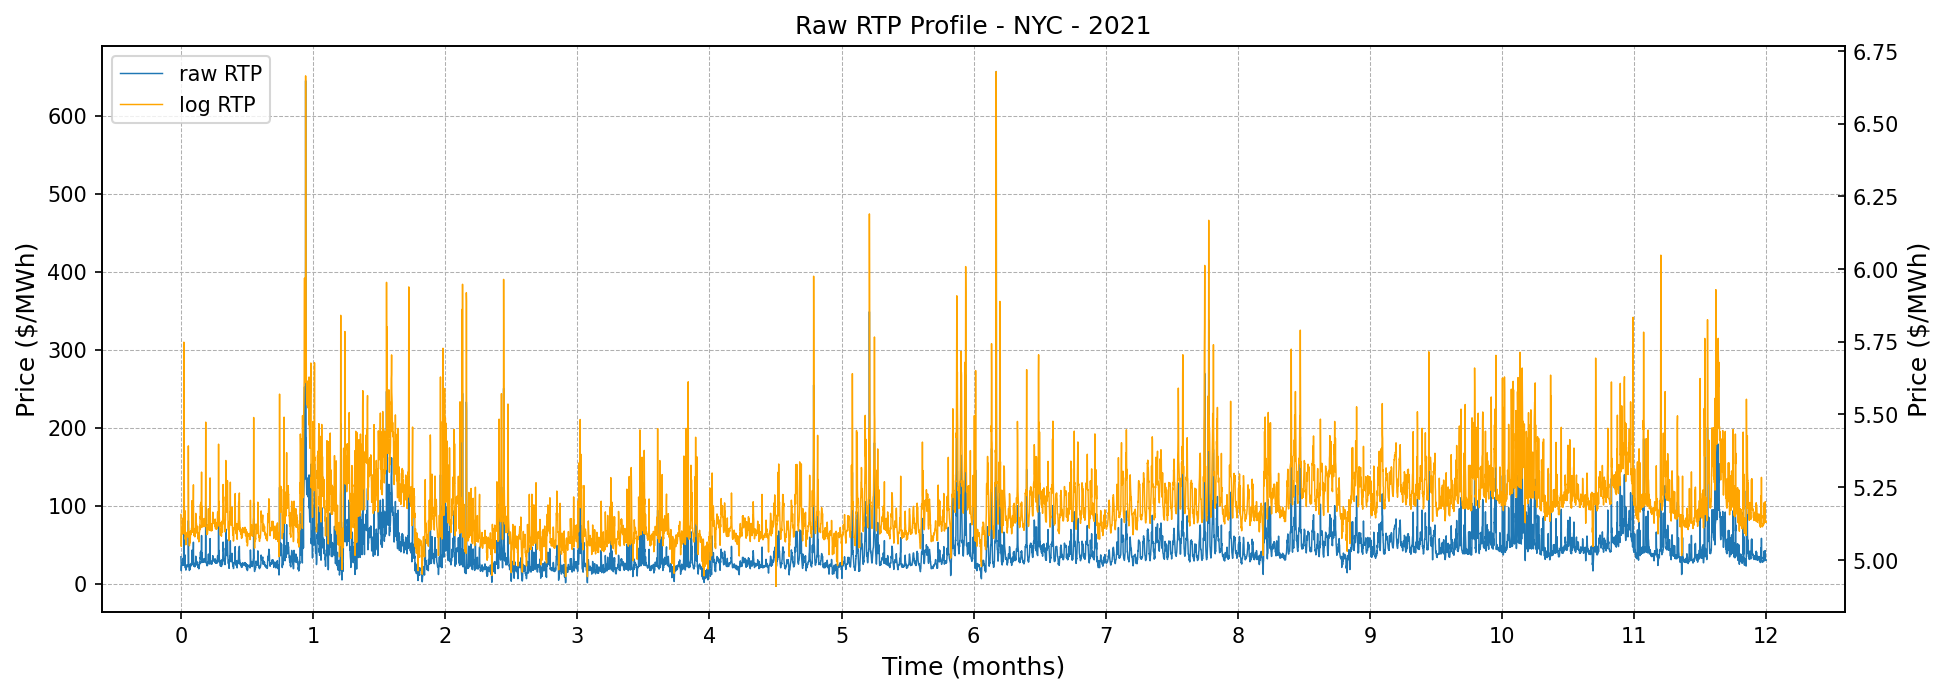

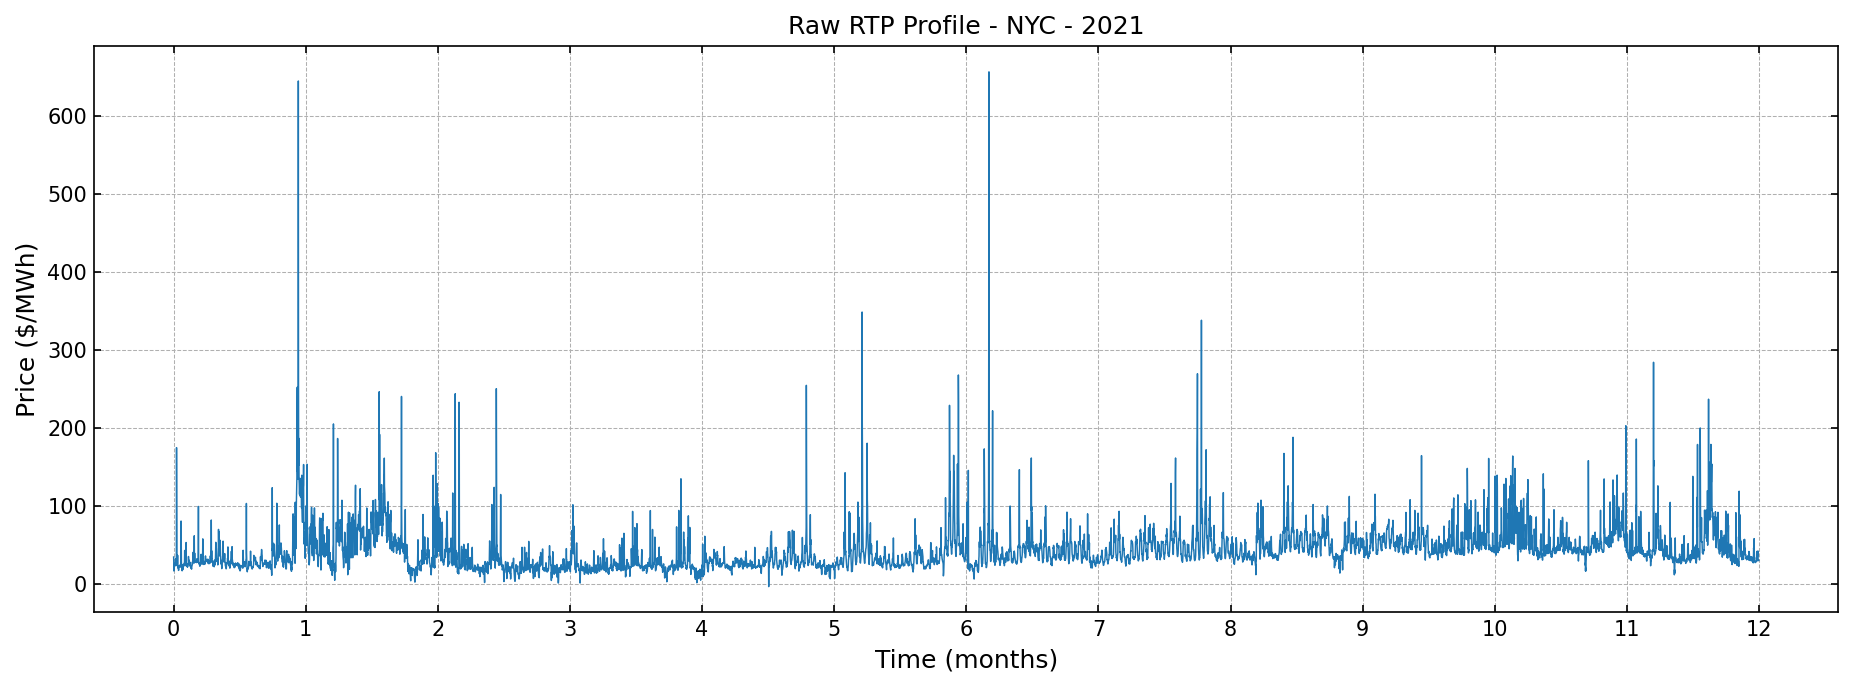

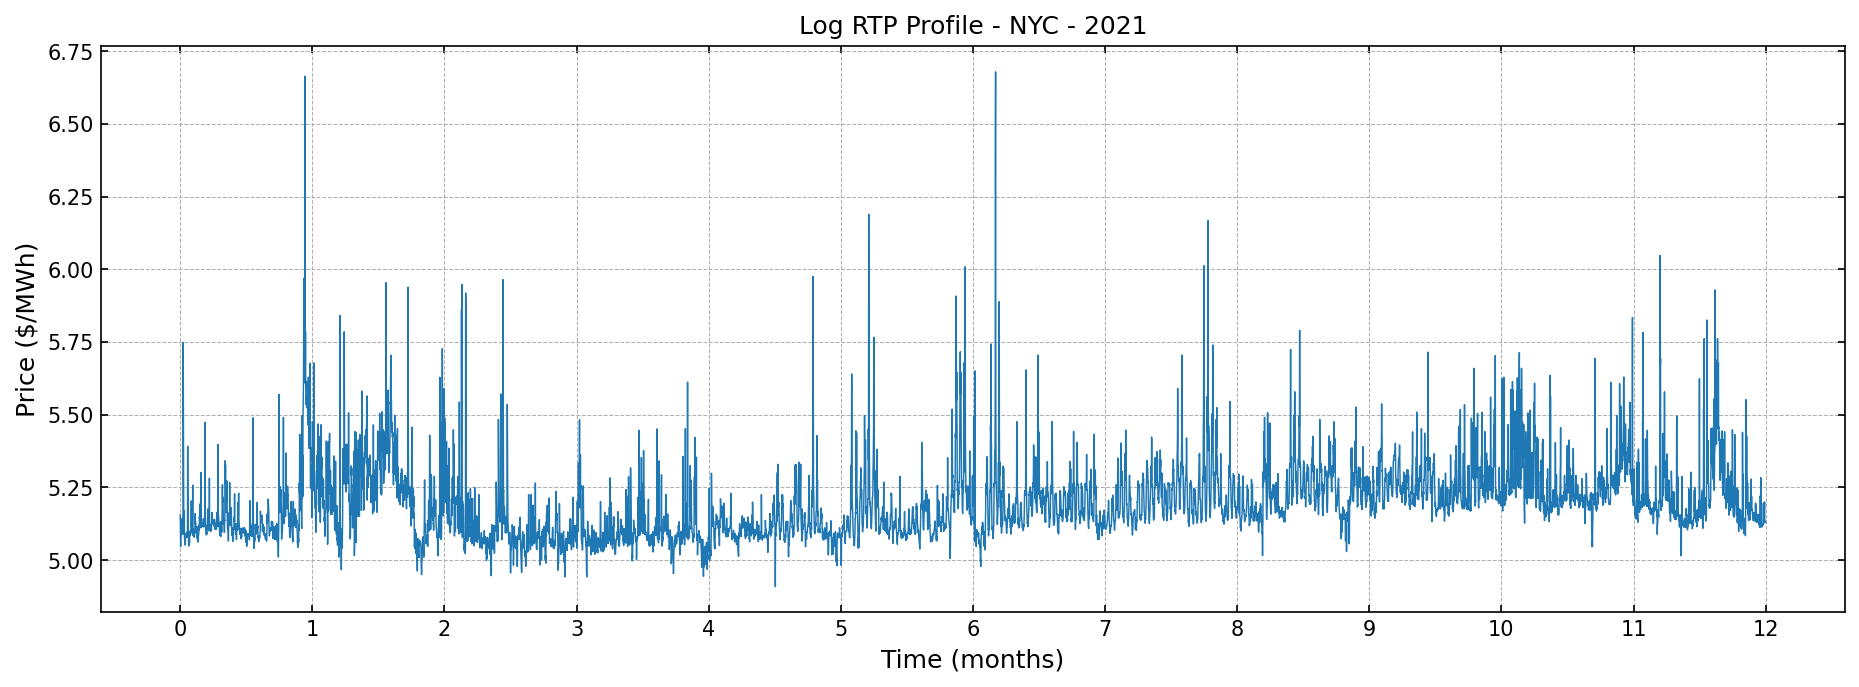

In [11]:
# Plot RTP for the testing year
plot_profile_twin(raw_data.iloc[43824-8760:, 2].values, log_data.iloc[43824-8760:, 2].values,
                  'RTP', 'Raw RTP Profile - NYC - 2021', "RTP_twin_2021_NYC", 'Price ($/MWh)')
plot_profile(raw_data.iloc[43824-8760:, 2].values, 'Raw RTP Profile - NYC - 2021', "RTP_raw_2021_NYC", 'Price ($/MWh)')
plot_profile(log_data.iloc[43824-8760:, 2].values, 'Log RTP Profile - NYC - 2021', "RTP_log_2021_NYC", 'Price ($/MWh)')

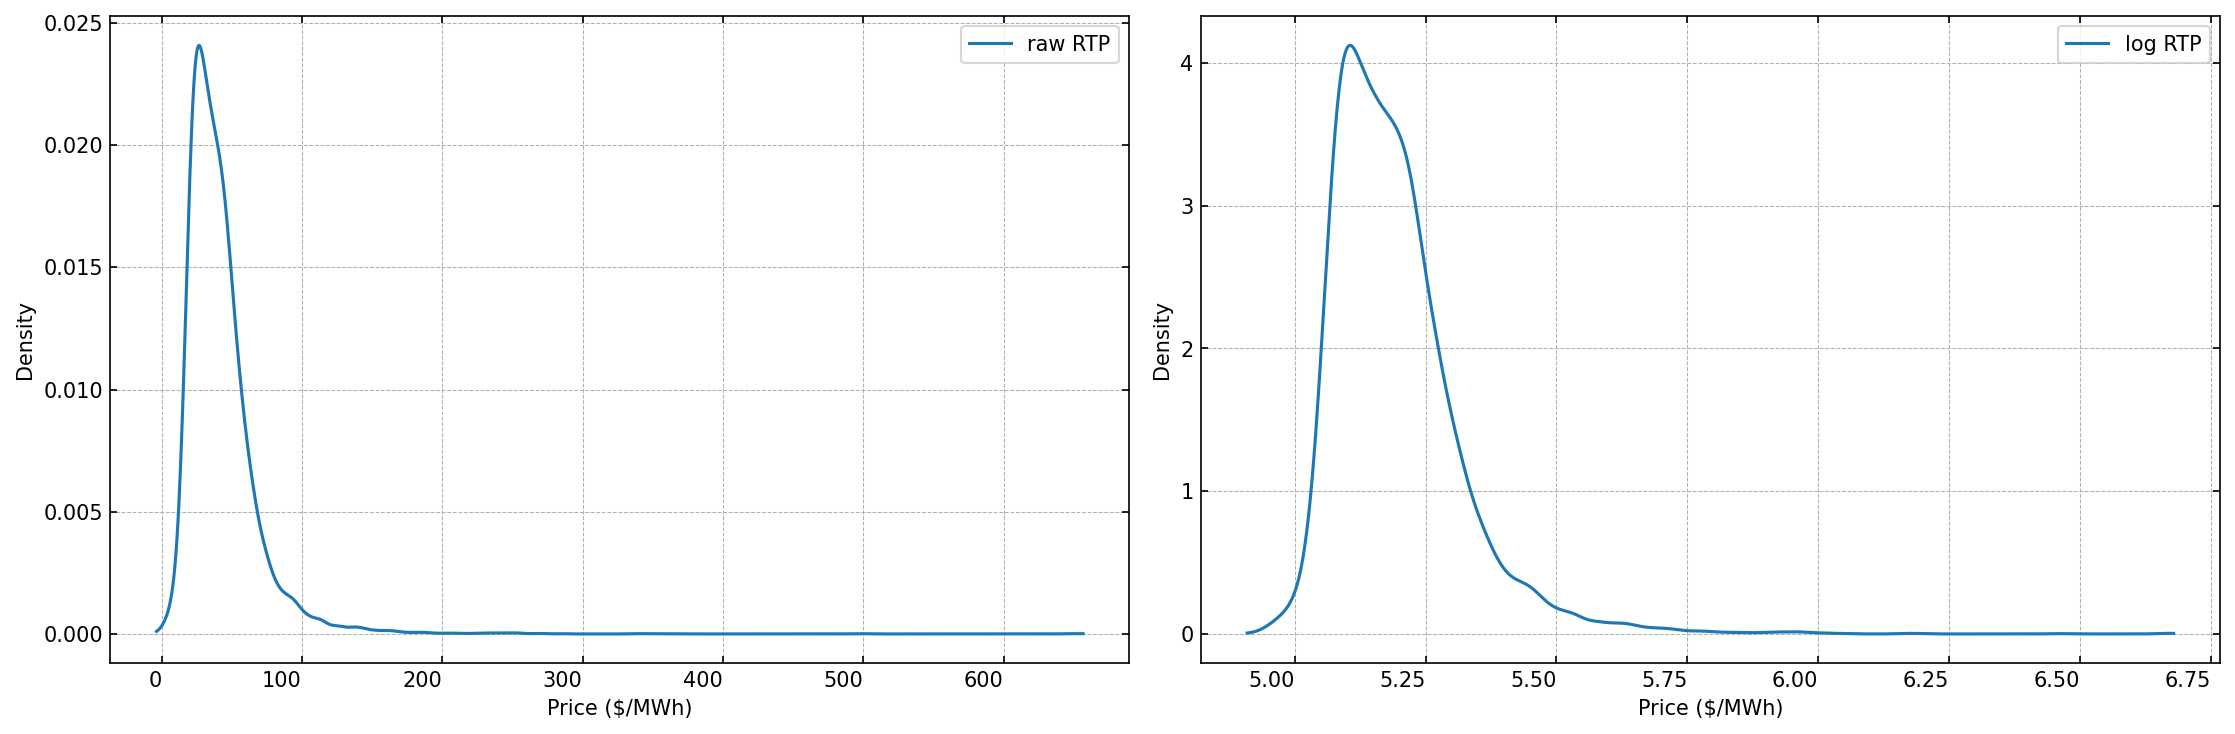

In [12]:
plot_distribution(raw_data.iloc[43824-8760:, 2].values, log_data.iloc[43824-8760:, 2].values,
                  'RTP', "dinsity_dist_raw_log")

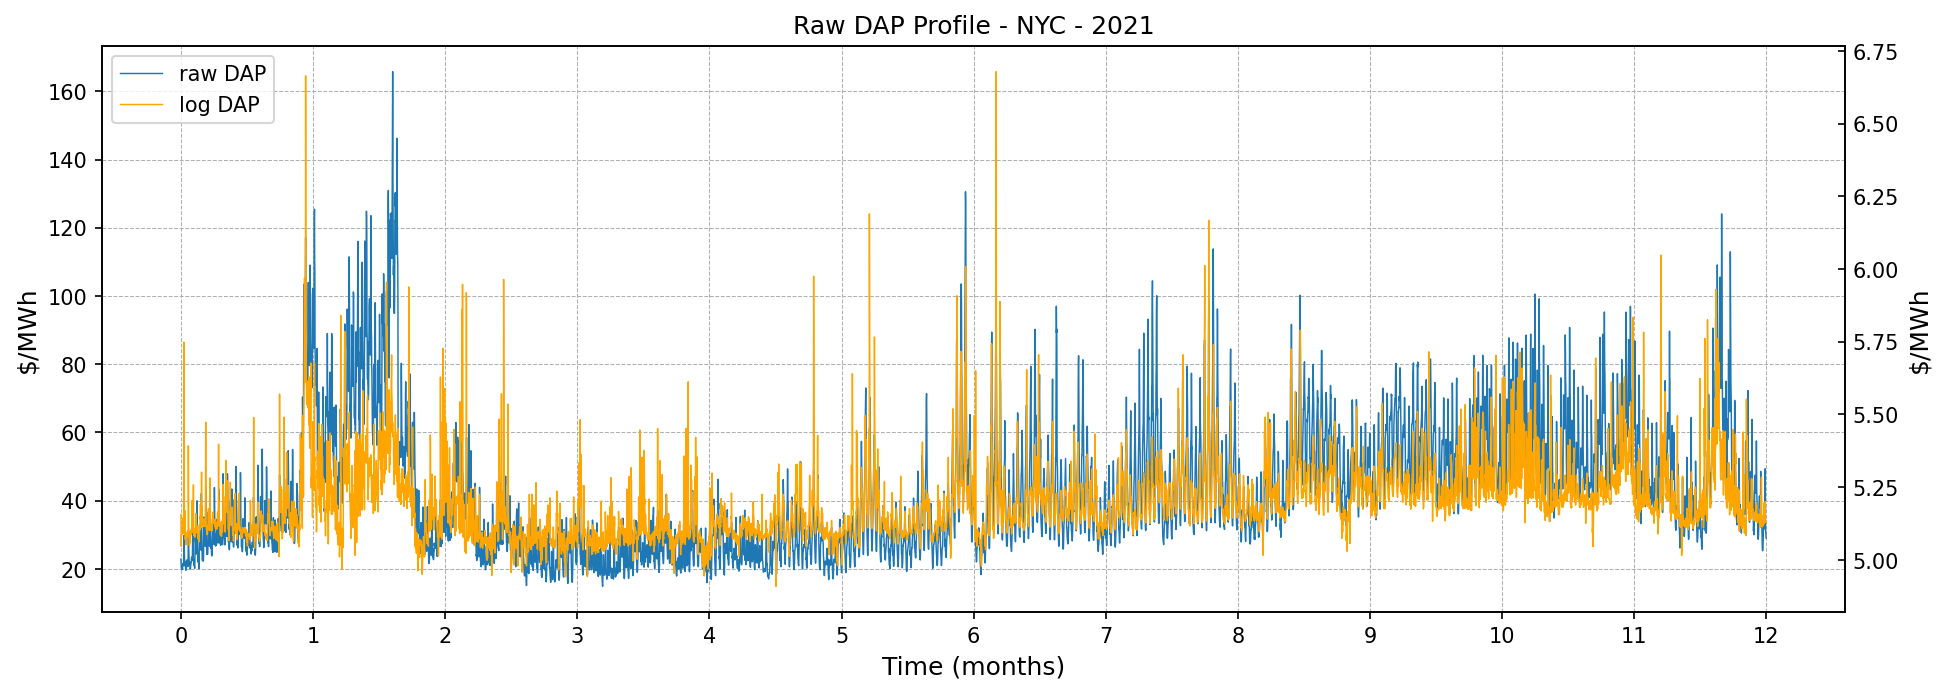

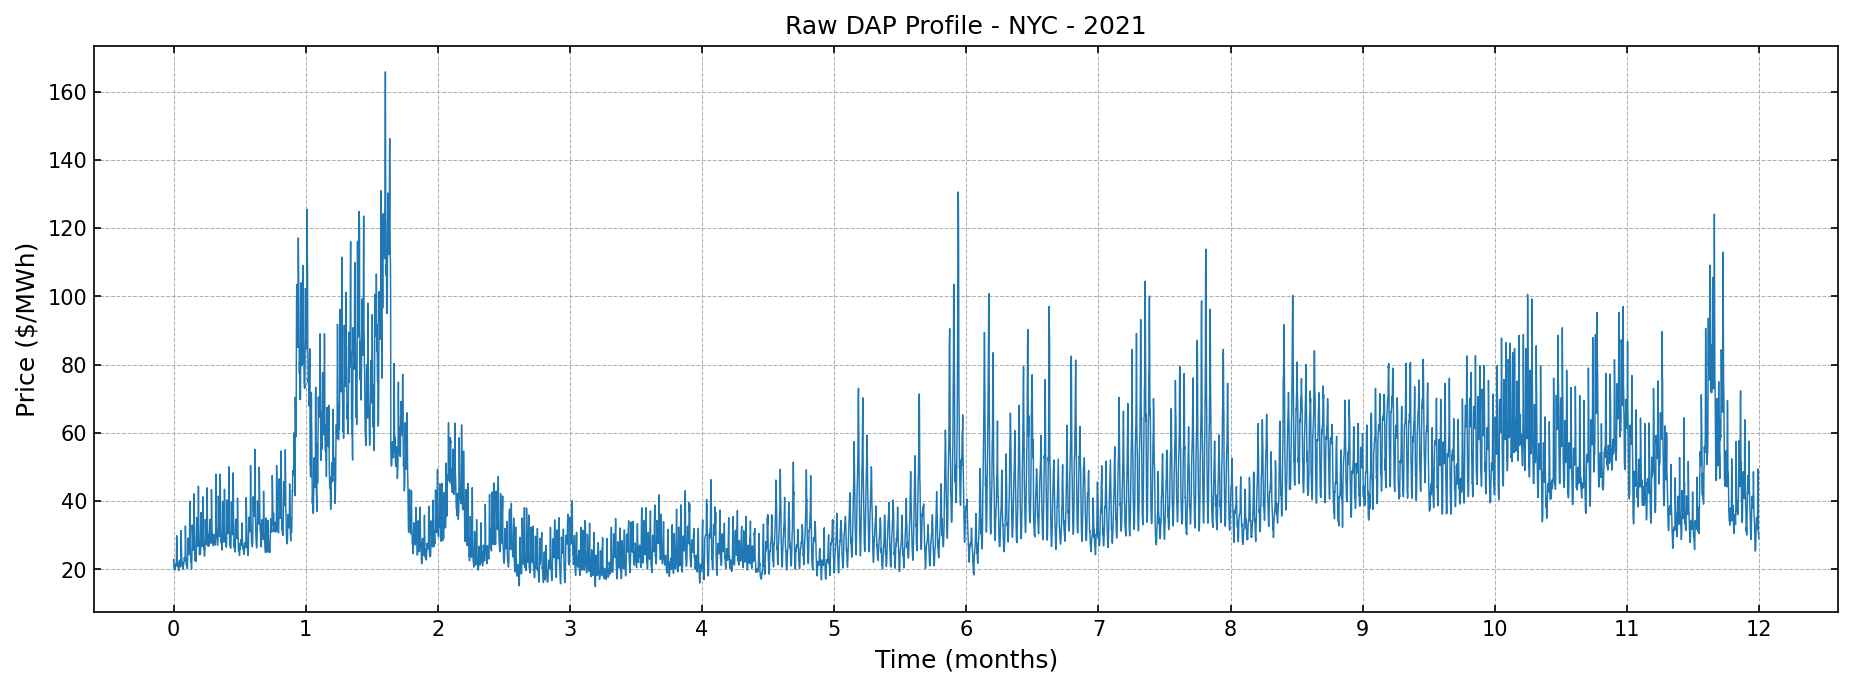

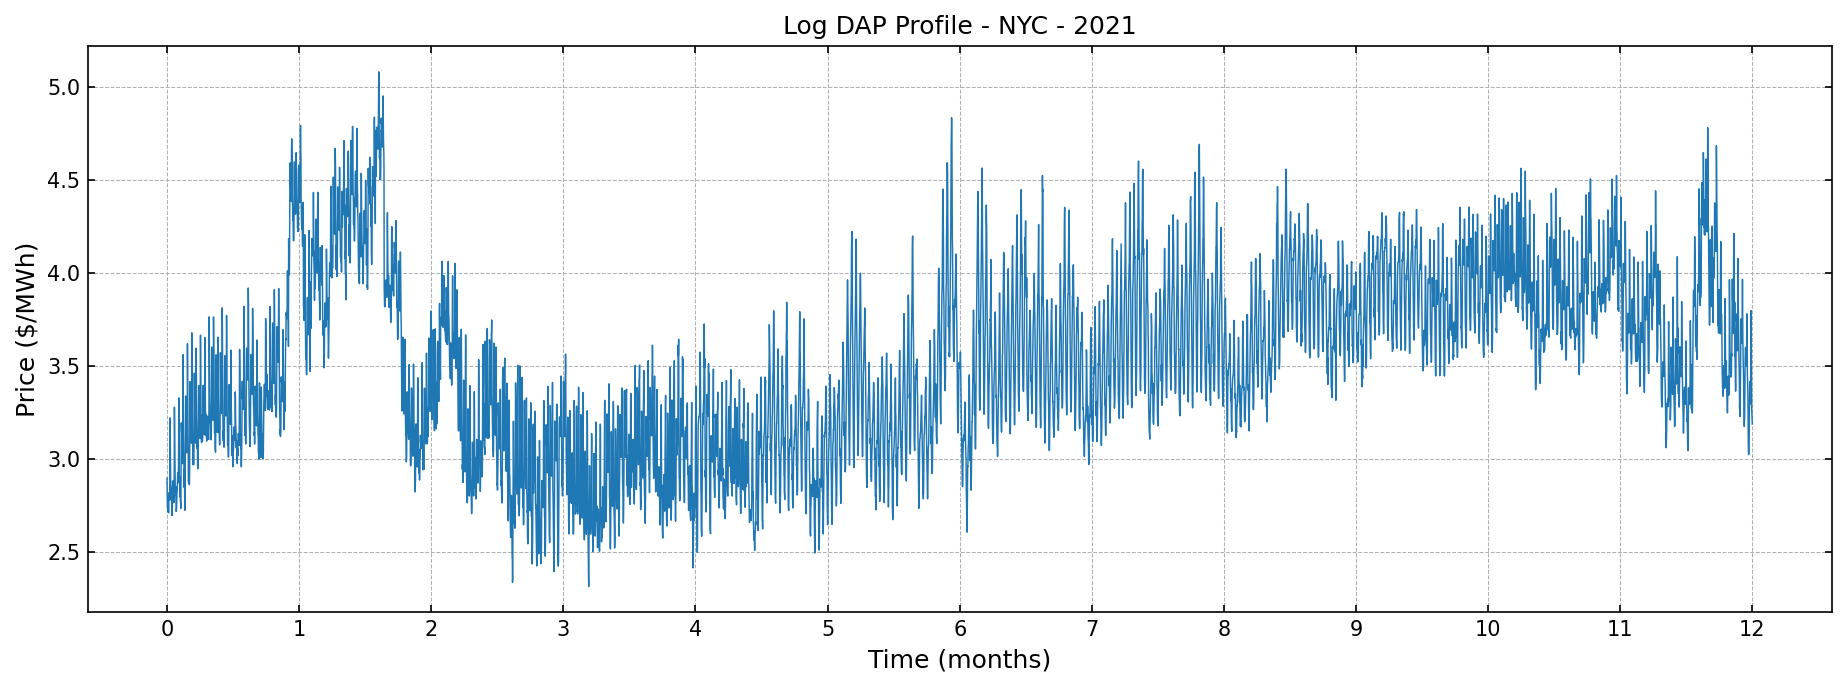

In [13]:
# Plot DAP for the testing year
plot_profile_twin(raw_data.iloc[43824-8760:, 0].values, log_data.iloc[43824-8760:, 2].values,
                  'DAP', 'Raw DAP Profile - NYC - 2021', "DAP_twin_2021_NYC", '$/MWh')
plot_profile(raw_data.iloc[43824-8760:, 0].values, 'Raw DAP Profile - NYC - 2021', "DAP_raw_2021_NYC", 'Price ($/MWh)')
plot_profile(log_data.iloc[43824-8760:, 0].values, 'Log DAP Profile - NYC - 2021', "DAP_log_2021_NYC", 'Price ($/MWh)')

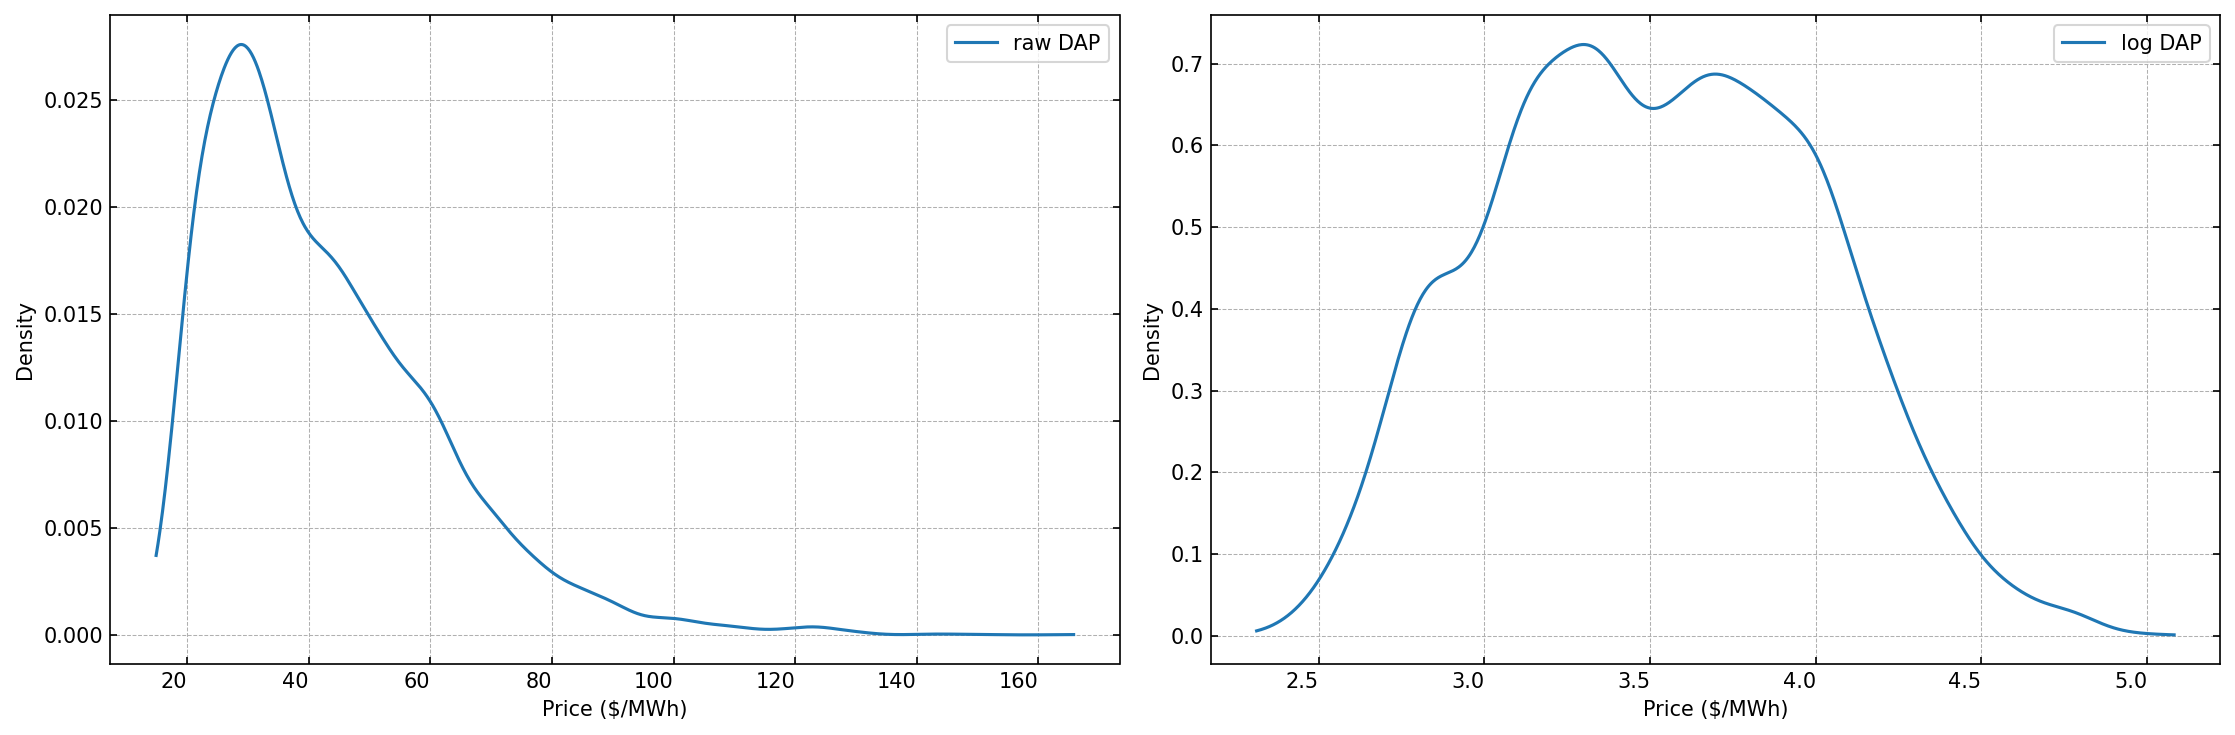

In [14]:
plot_distribution(raw_data.iloc[43824-8760:, 0].values, log_data.iloc[43824-8760:, 0].values,
                  'DAP', "dinsity_dist_raw_log_DAP")

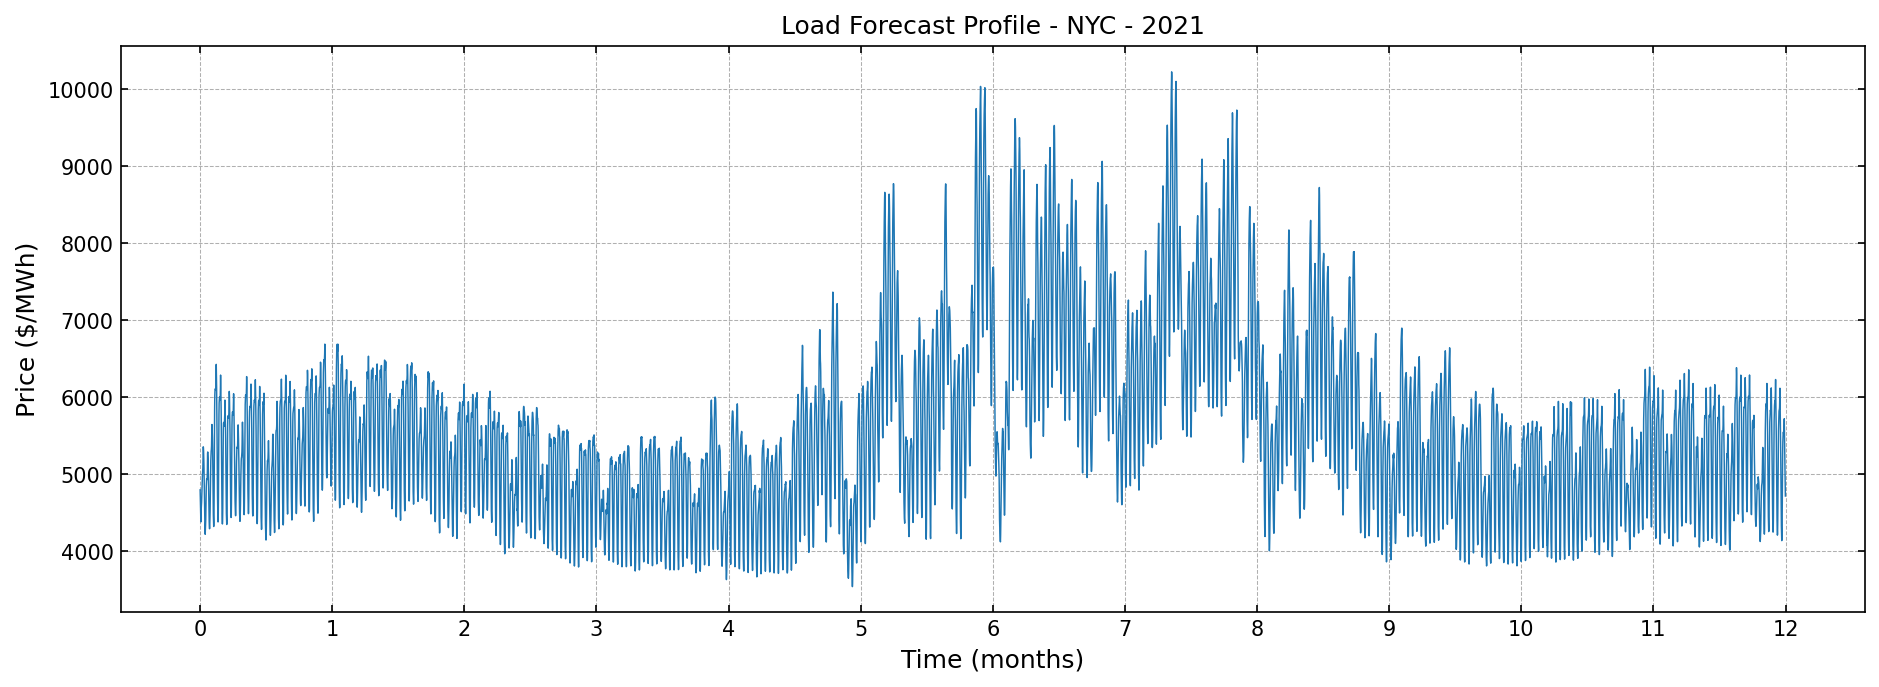

In [15]:
# Plot Load Forecast for the testing year
plot_profile(raw_data.iloc[43824-8760:, 1].values, 'Load Forecast Profile - NYC - 2021', "LF_2021_NYC", 'Price ($/MWh)')

### Data Preprocessing

In [11]:
# Split dataset: 2015 year for training and 2016-2017 years for testing
x_train_df = log_data.iloc[:8760*4+24,:]
x_test_df = log_data.iloc[8760*4+24:,:]

y_train_df = log_data.iloc[:8760*4+24,2:]
y_test_df = log_data.iloc[8760*4+24:,2:]

In [12]:
# Standardization
x_mean, x_std = x_train_df.mean(), x_train_df.std()
y_mean, y_std = y_train_df.mean(), y_train_df.std()

x_train = ((x_train_df - x_mean)/x_std).to_numpy()
x_test = ((x_test_df - x_mean)/x_std).to_numpy()

y_train = ((y_train_df - y_mean)/y_std).to_numpy()
y_test = ((y_test_df - y_mean)/y_std).to_numpy()

print(x_train.shape,y_train.shape,x_test.shape, y_test.shape)

(35064, 3) (35064, 1) (8760, 3) (8760, 1)


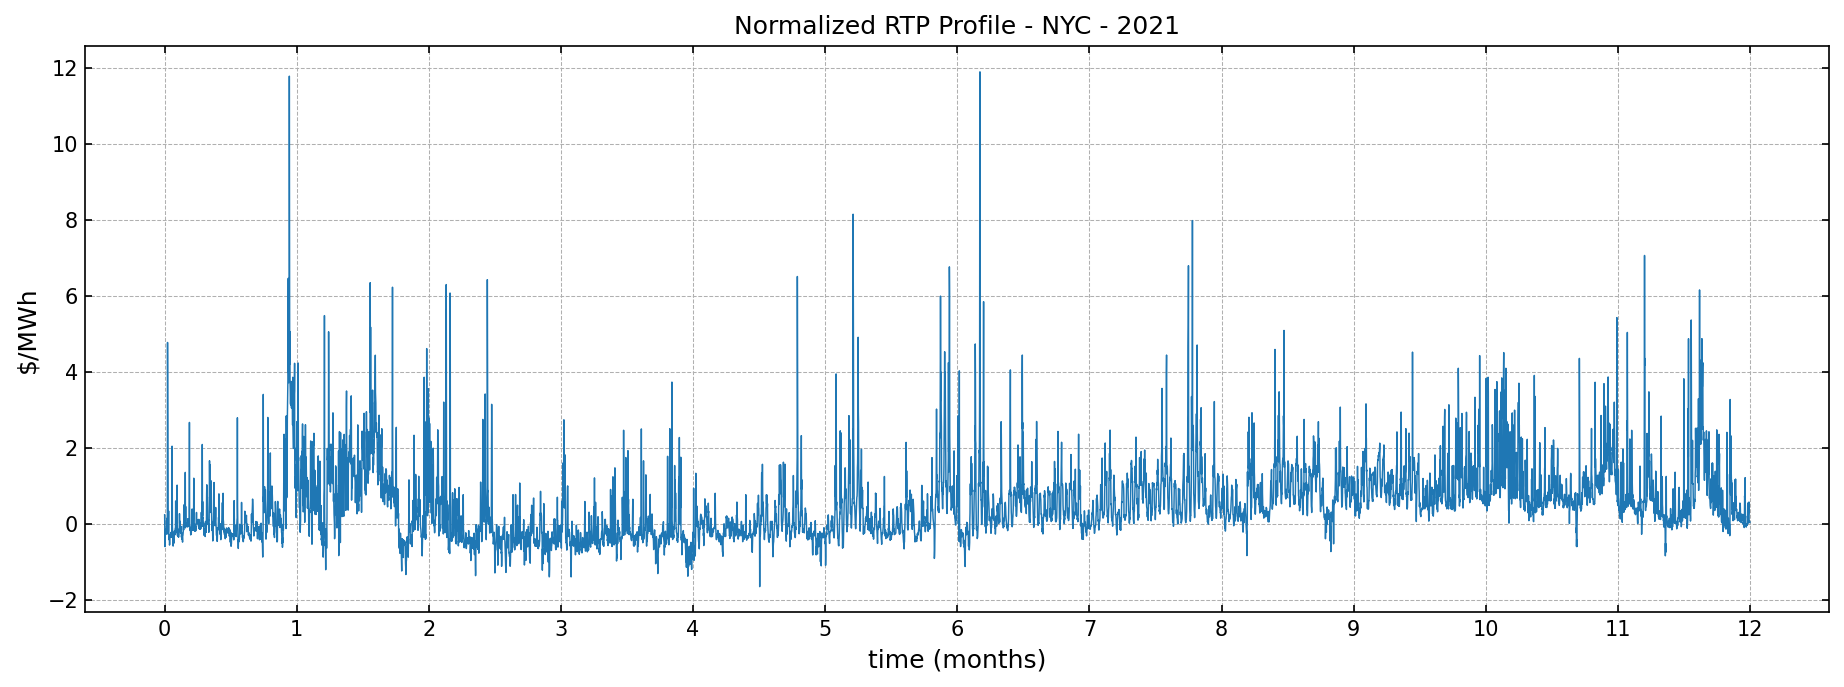

In [18]:
plot_profile(x_test[:,2], 'Normalized RTP Profile - NYC - 2021', "RTP_normalized_2021_NYC", '$/MWh')


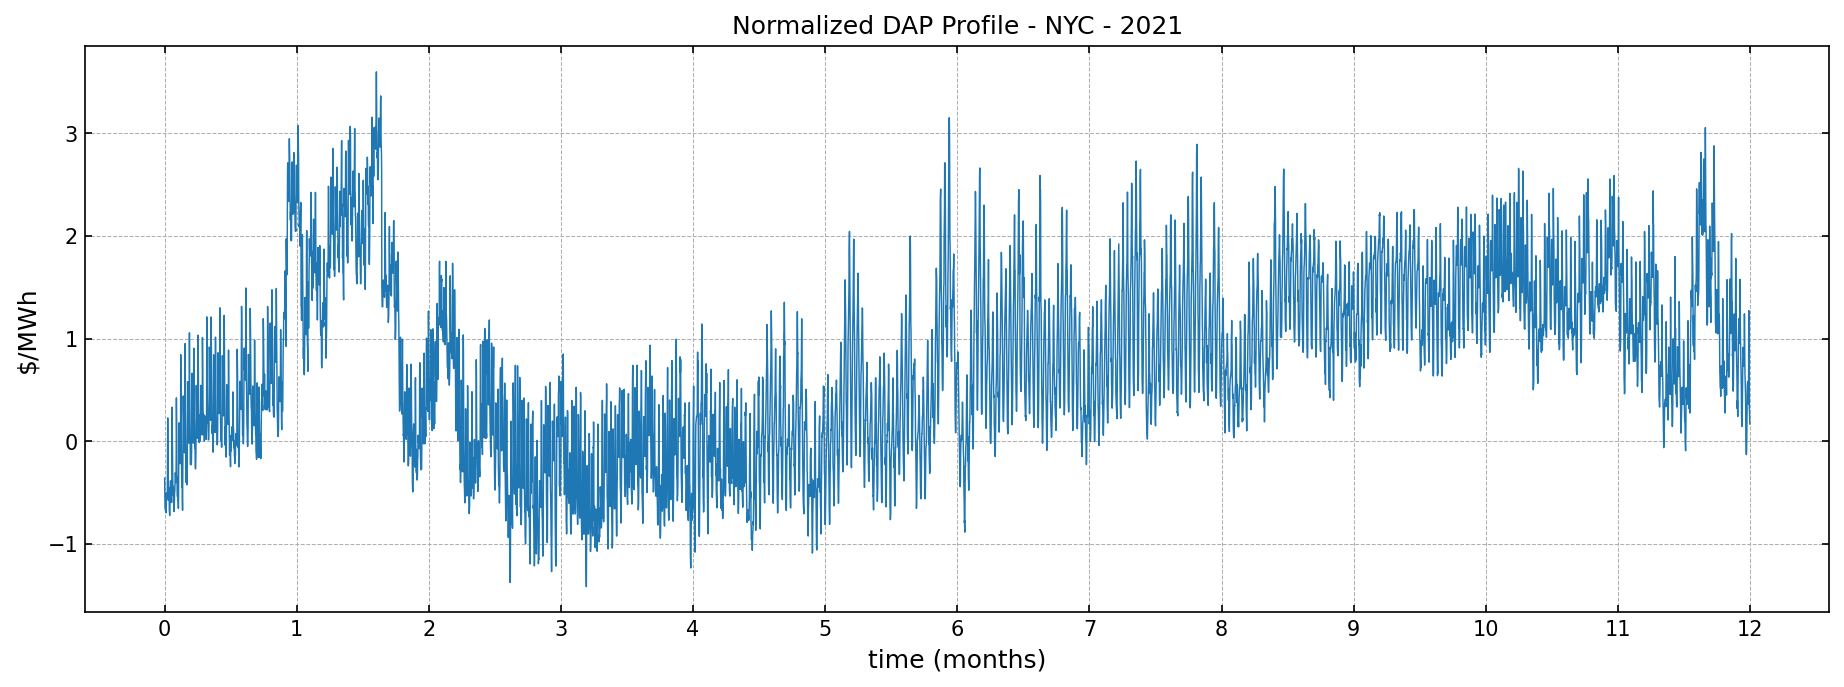

In [19]:
plot_profile(x_test[:,0], 'Normalized DAP Profile - NYC - 2021', "DAP_normalized_2021_NYC", '$/MWh')


# Deciding the best model
comparing all the models (CNN, CNN-LSTM). 

The next steps will compare between the models for each version (24 lags, 48, and 72)

We will load the model and generate predictions and rescale it to actual values and plot figures for the errors and the predictions

### lag 24

In [13]:
model_path = 'saved_model/'

In [20]:
n_steps_in = 24
n_steps_out = 24
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

model_path = 'saved_model/'

lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_24h.h5'))
y_test_pred_lstm_24 = lstm_model.predict(x_test_lstm)
cnn_model = load_model(os.path.join(model_path,'cnn_model_best_24h.h5'))
y_test_pred_cnn_24 = cnn_model.predict(x_test_lstm)
cnn_lstm_model = load_model(os.path.join(model_path,'cnn_lstm_model_best_24h.h5'))
y_test_pred_cnn_lstm_24 = cnn_lstm_model.predict(x_test_lstm)

273/273 [==============================] - 1s 1ms/step


In [21]:
y_test_pred_lstm_rescale_24 = y_test_pred_lstm_24*y_std.values + y_mean.values
y_test_lstm_rescale_24 = y_test_lstm_24*y_std.values + y_mean.values
y_test_pred_lstm_invlog_24 = np.exp(y_test_pred_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_24 = np.exp(y_test_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_rescale_24 = y_test_pred_cnn_24*y_std.values + y_mean.values
y_test_pred_cnn_invlog_24 = np.exp(y_test_pred_cnn_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_lstm_rescale_24 = y_test_pred_cnn_lstm_24*y_std.values + y_mean.values
y_test_pred_cnn_lstm_invlog_24 = np.exp(y_test_pred_cnn_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

LSTM MAE: 11.8169

CNN MAE: 10.2440

CNN-LSTM MAE: 11.6092



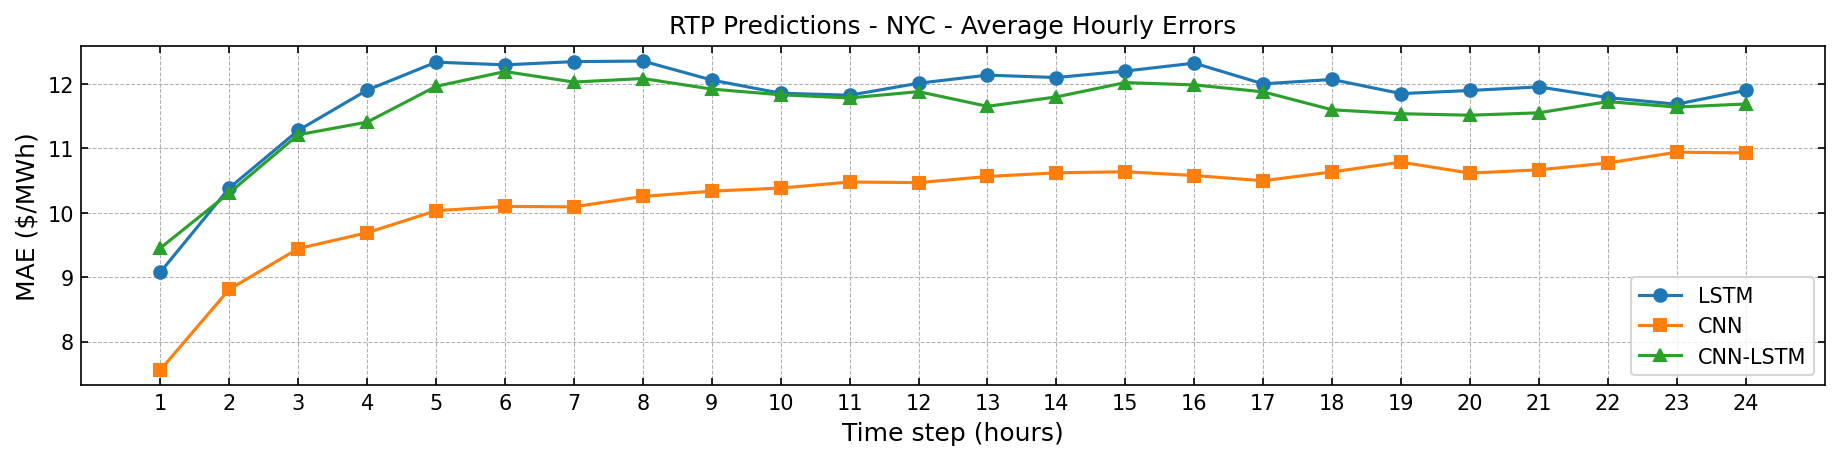

In [22]:
# Evaluation metrics
# 24 hours ahead
# Evaluation metrics
errors_lstm = y_test_pred_lstm_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('LSTM MAE: {:.4f}'.format(np.abs(errors_lstm).mean()))
print('')

errors_cnn = y_test_pred_cnn_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('CNN MAE: {:.4f}'.format(np.abs(errors_cnn).mean()))
print('')

errors_cnn_lstm = y_test_pred_cnn_lstm_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('CNN-LSTM MAE: {:.4f}'.format(np.abs(errors_cnn_lstm).mean()))
print('')

errors_h_cnn = []
errors_h_cnn_lstm = []
errors_h_lstm = []
for i in range(24):
    # Evaluation metrics for hour ahead only
    errors_h_lstm.append(y_test_pred_lstm_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])
    errors_h_cnn.append(y_test_pred_cnn_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])
    errors_h_cnn_lstm.append(y_test_pred_cnn_lstm_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])

plot_hourly_errors(np.abs(errors_h_lstm).mean(axis=1), np.abs(errors_h_cnn).mean(axis=1), np.abs(errors_h_cnn_lstm).mean(axis=1),
                   'RTP Predictions - NYC - Average Hourly Errors', 'hourly_errors_24_lags')

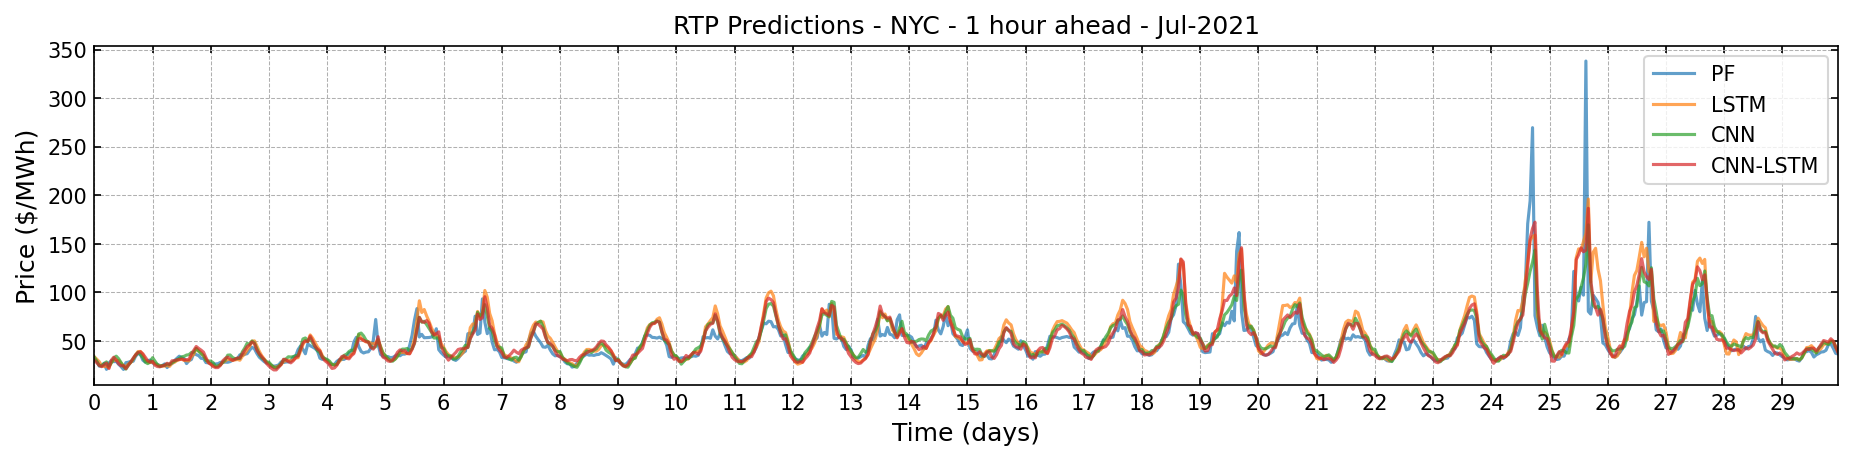

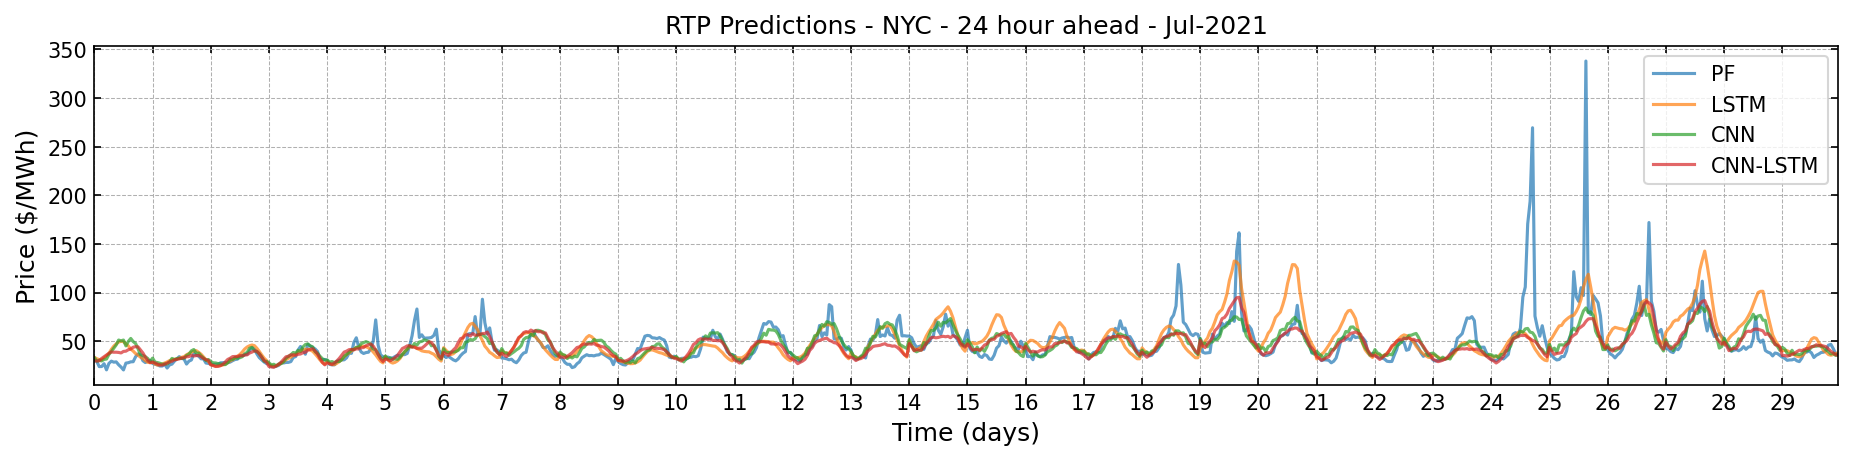

In [23]:
i = 7*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021', 'Time (days)', 'hourly_predictions_jul_24_lags')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021', 'Time (days)', '24ha_predictions_jul_24_lags')

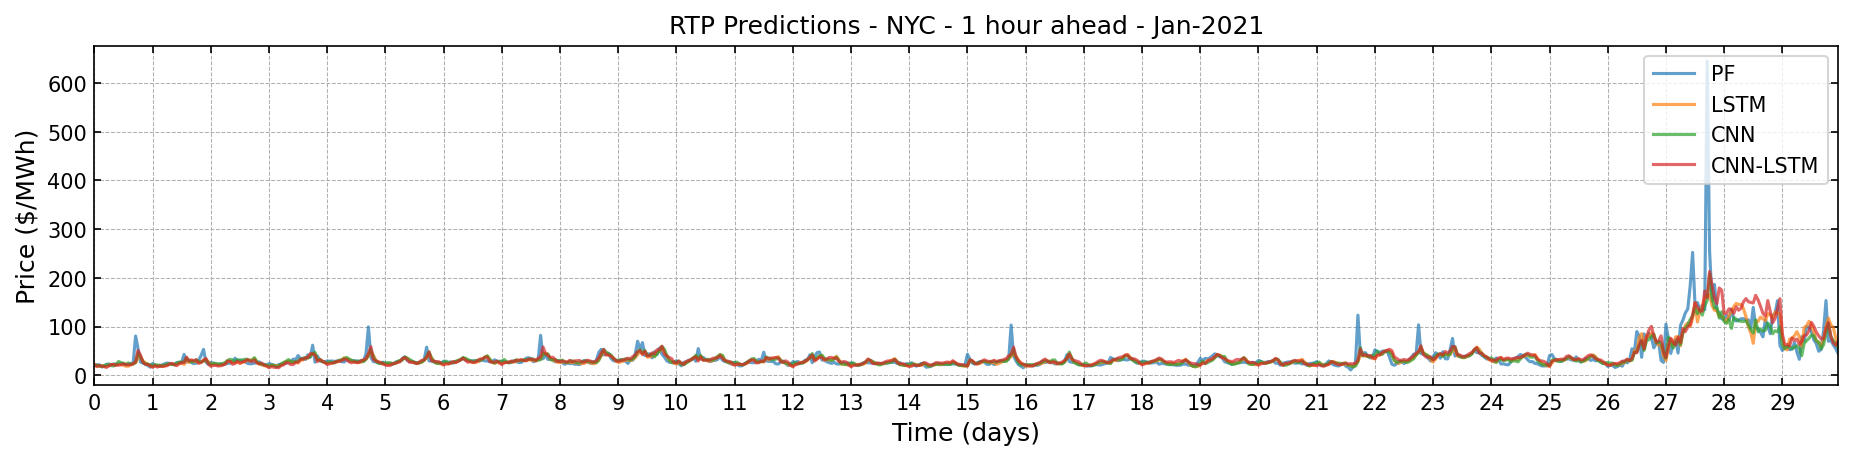

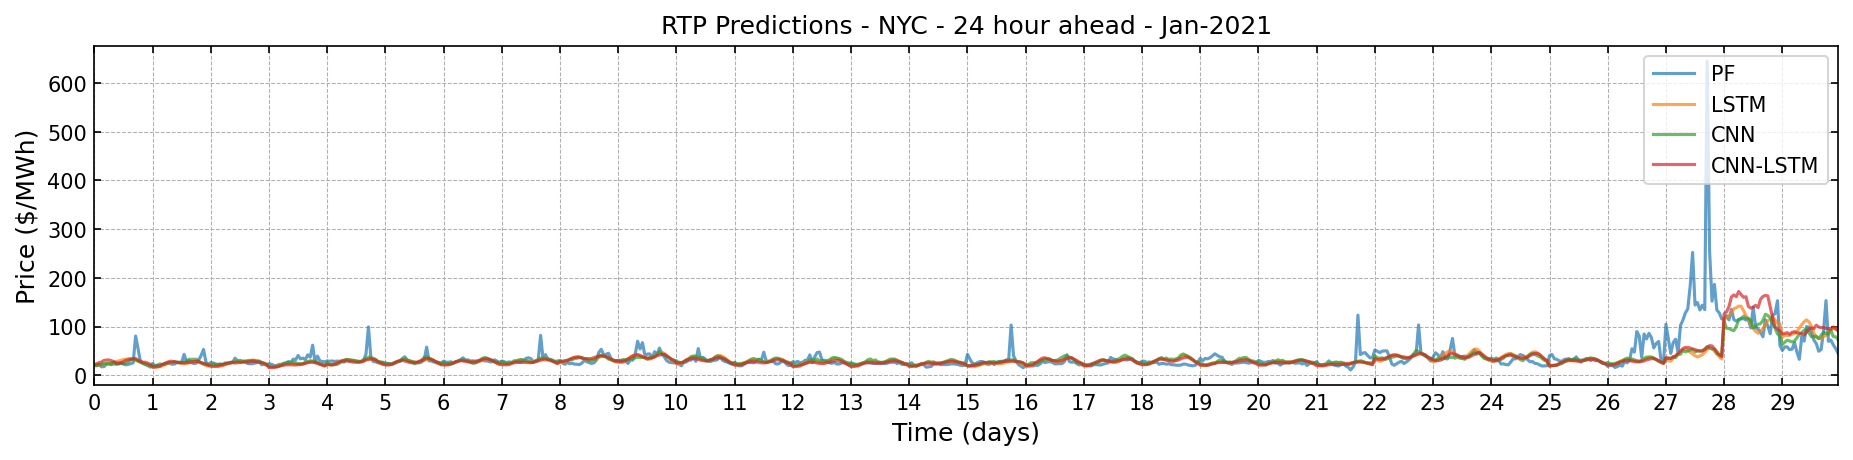

In [24]:
i = 0*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021', 'Time (days)', 'hourly_predictions_jan_24_lags')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021', 'Time (days)', '24ha_predictions_jan_24_lags')

### lag 48

In [14]:
n_steps_in = 48
n_steps_out = 24
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_48h.h5'))
y_test_pred_lstm_24 = lstm_model.predict(x_test_lstm)
cnn_model = load_model(os.path.join(model_path,'CNN_model_best_48h.h5'))
y_test_pred_cnn_24 = cnn_model.predict(x_test_lstm)
cnn_lstm_model = load_model(os.path.join(model_path,'CNN_LSTM_model_best_48h.h5'))
y_test_pred_cnn_lstm_24 = cnn_lstm_model.predict(x_test_lstm)

272/272 [==============================] - 1s 2ms/step


In [15]:
y_test_pred_lstm_rescale_24 = y_test_pred_lstm_24*y_std.values + y_mean.values
y_test_lstm_rescale_24 = y_test_lstm_24*y_std.values + y_mean.values
y_test_pred_lstm_invlog_24 = np.exp(y_test_pred_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_24 = np.exp(y_test_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_rescale_24 = y_test_pred_cnn_24*y_std.values + y_mean.values
y_test_pred_cnn_invlog_24 = np.exp(y_test_pred_cnn_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_lstm_rescale_24 = y_test_pred_cnn_lstm_24*y_std.values + y_mean.values
y_test_pred_cnn_lstm_invlog_24 = np.exp(y_test_pred_cnn_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

LSTM MAE: 12.1817

CNN MAE: 10.0895

CNN-LSTM MAE: 11.1771



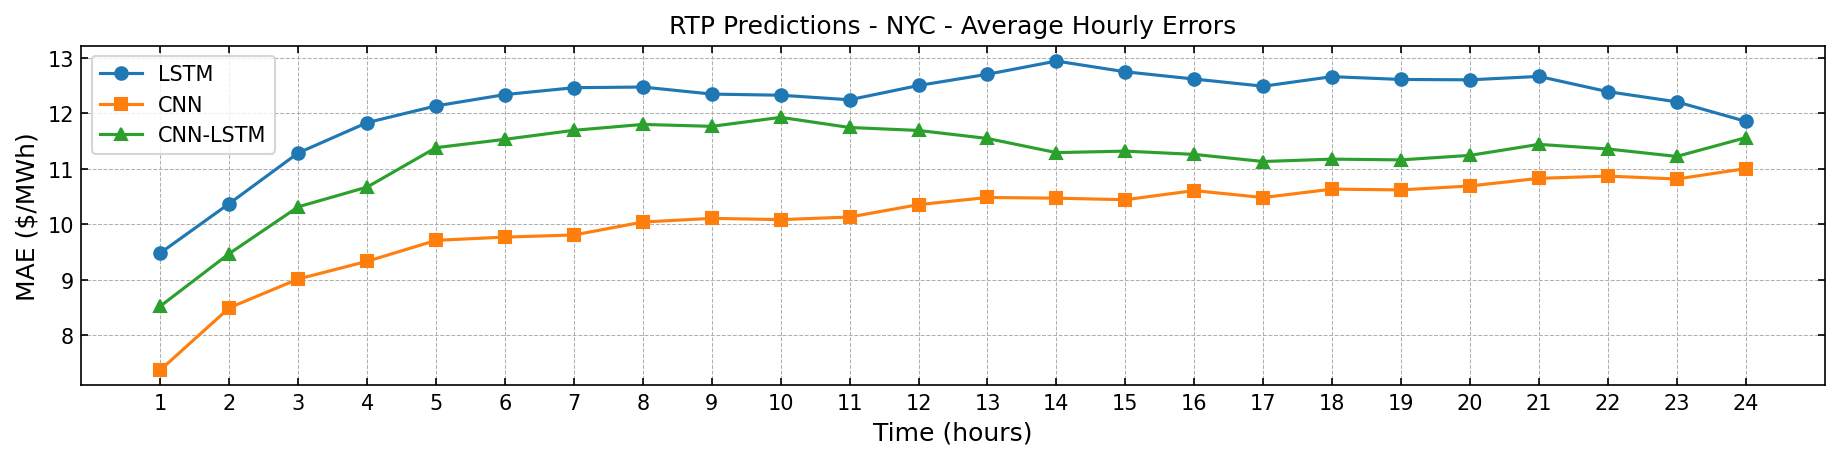

In [16]:
# Evaluation metrics
# 24 hours ahead
# Evaluation metrics
errors_lstm = y_test_pred_lstm_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('LSTM MAE: {:.4f}'.format(np.abs(errors_lstm).mean()))
print('')

errors_cnn = y_test_pred_cnn_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('CNN MAE: {:.4f}'.format(np.abs(errors_cnn).mean()))
print('')

errors_cnn_lstm = y_test_pred_cnn_lstm_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('CNN-LSTM MAE: {:.4f}'.format(np.abs(errors_cnn_lstm).mean()))
print('')

errors_h_cnn = []
errors_h_cnn_lstm = []
errors_h_lstm = []
for i in range(24):
    # Evaluation metrics for hour ahead only
    errors_h_lstm.append(y_test_pred_lstm_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])
    errors_h_cnn.append(y_test_pred_cnn_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])
    errors_h_cnn_lstm.append(y_test_pred_cnn_lstm_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])


plot_hourly_errors(np.abs(errors_h_lstm).mean(axis=1), np.abs(errors_h_cnn).mean(axis=1), np.abs(errors_h_cnn_lstm).mean(axis=1),
                   'RTP Predictions - NYC - Average Hourly Errors', 'hourly_errors_48_lags')

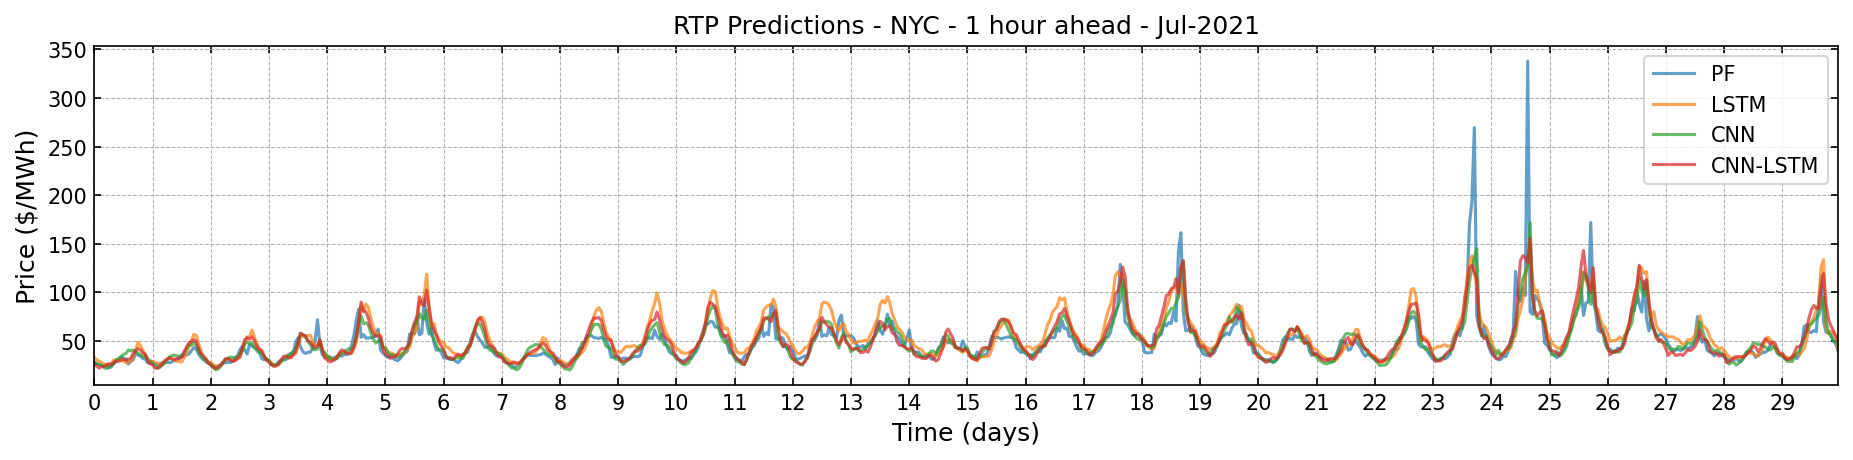

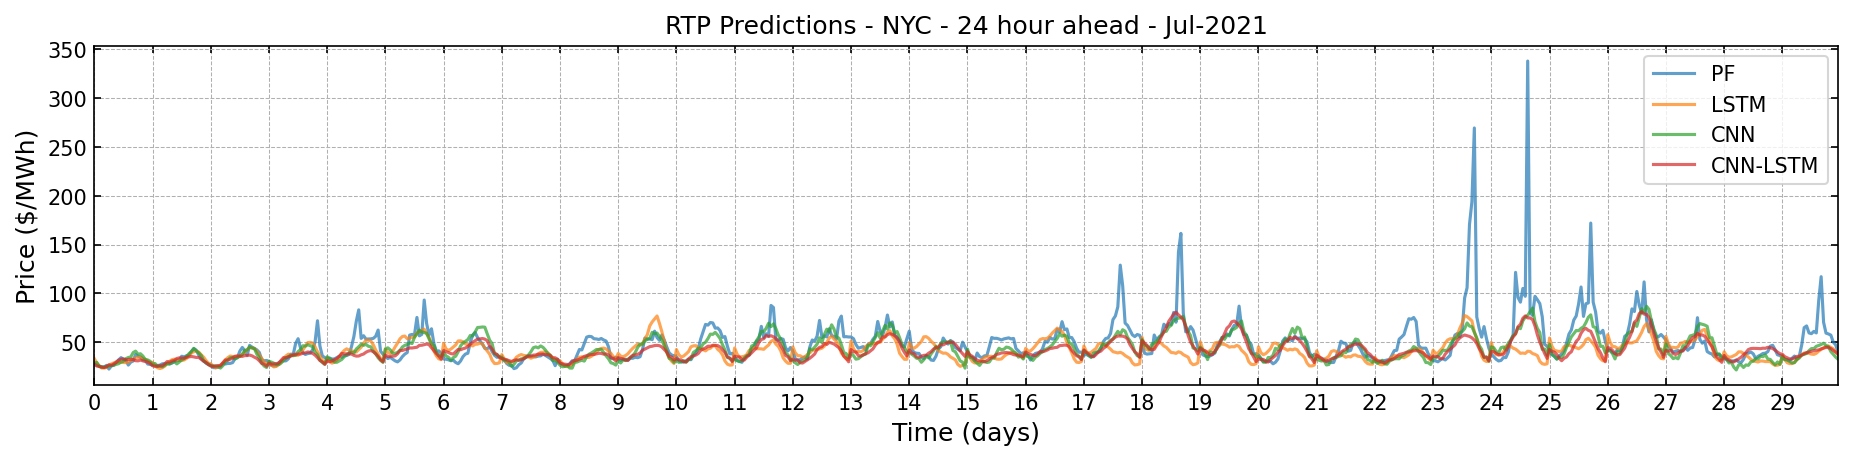

In [28]:
i = 7*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021', 'Time (days)',  'hourly_predictions_jul_48_lags')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021', 'Time (days)',  '24ha_predictions_jul_48_lags')

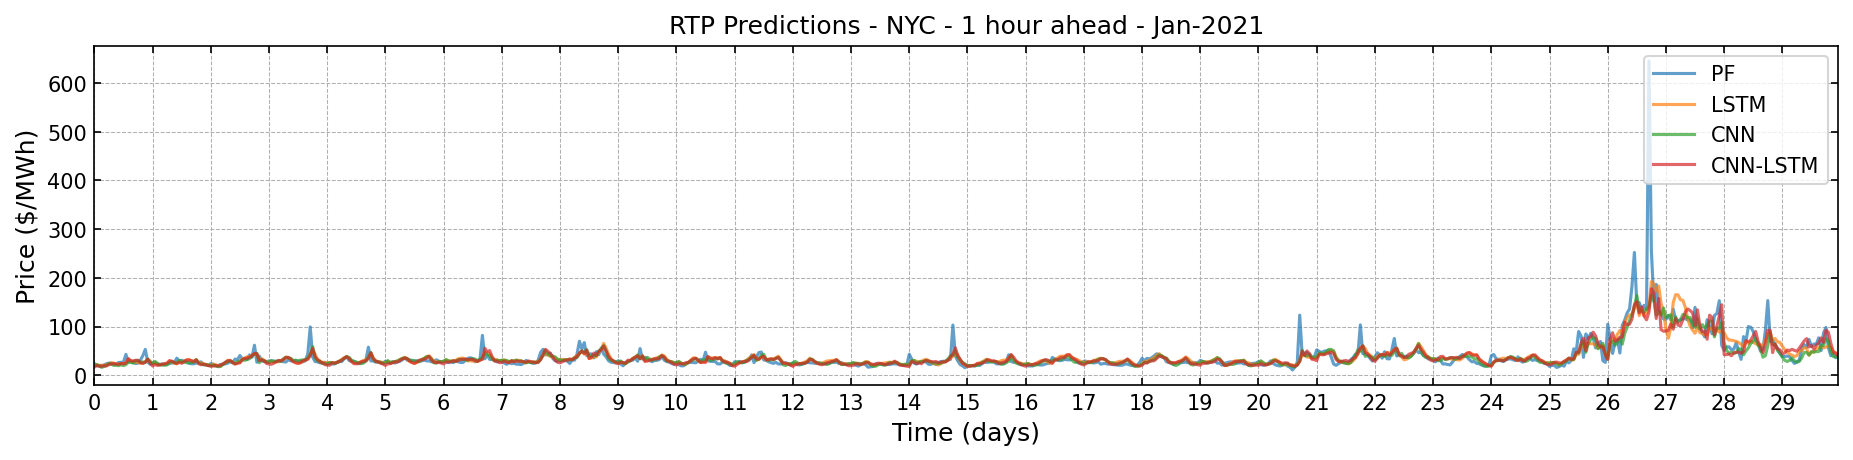

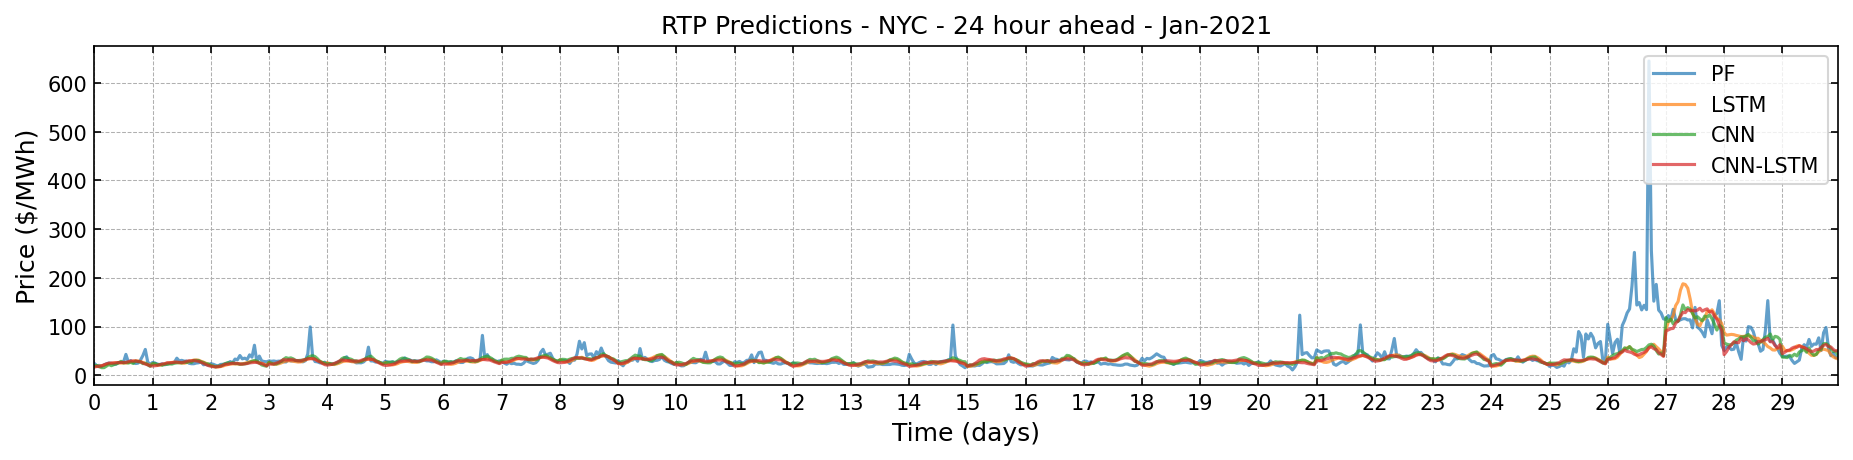

In [29]:
i = 0*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021', 'Time (days)',  'hourly_predictions_jan_48_lags')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021', 'Time (days)',  '24ha_predictions_jan_48_lags')

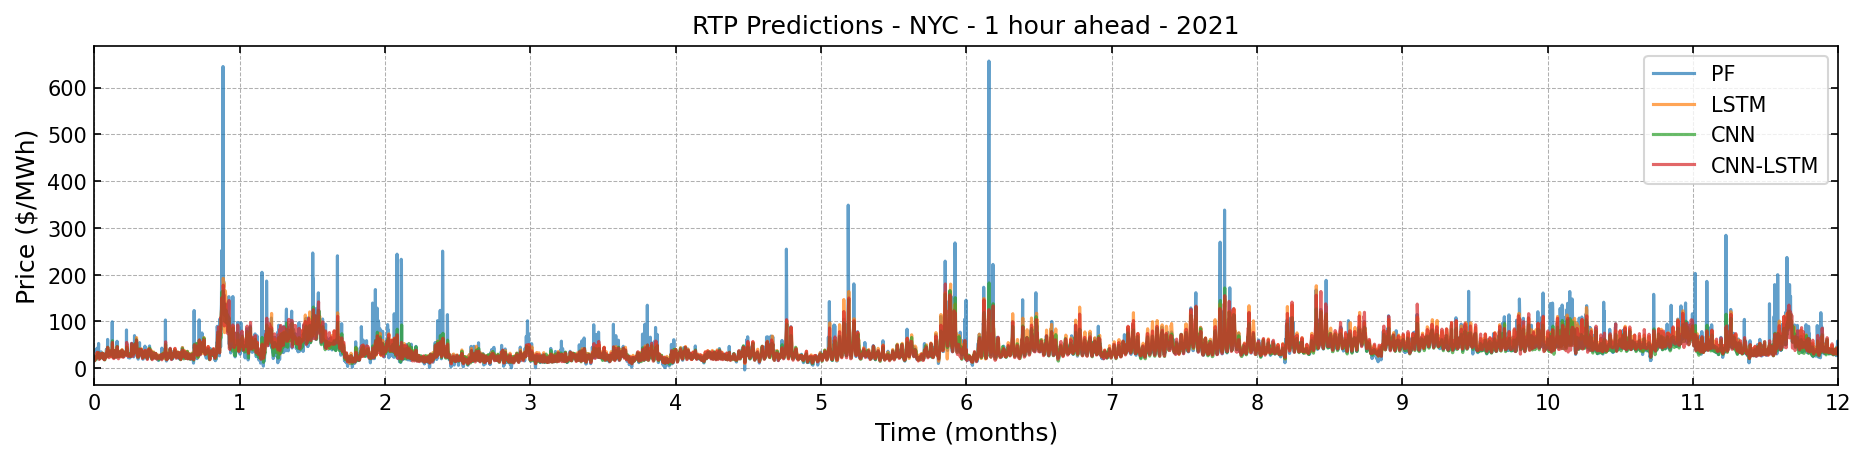

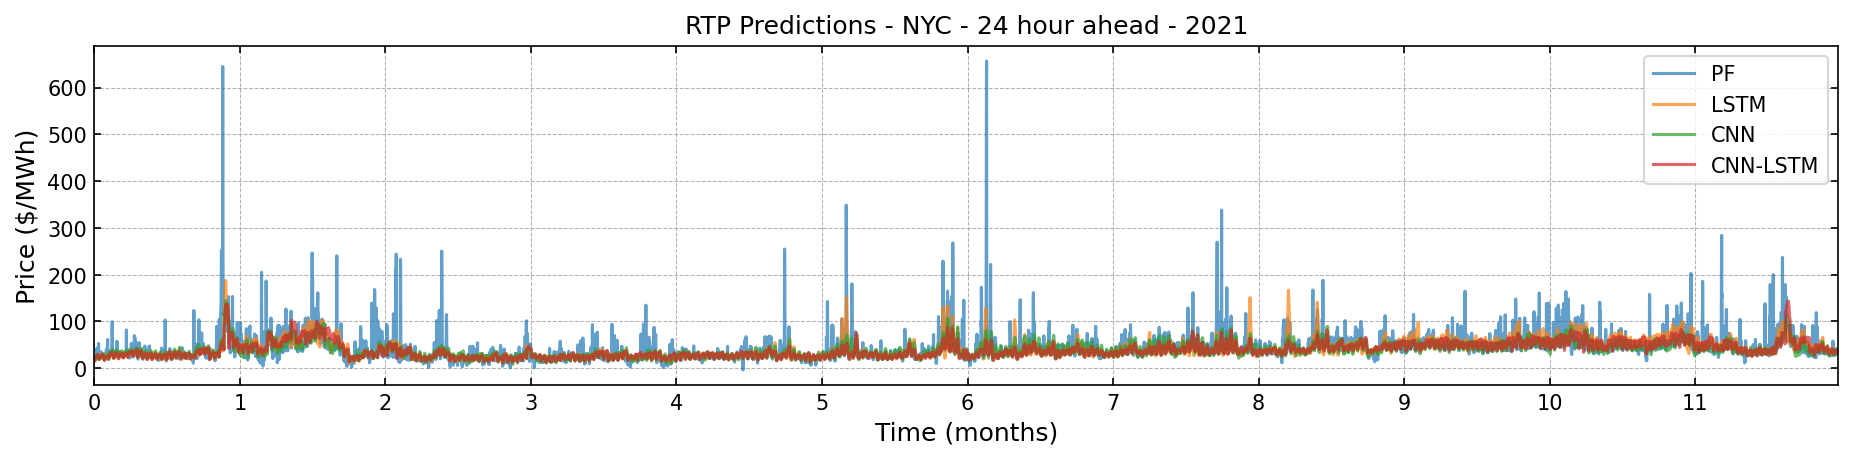

In [39]:
plot_predictions_models(y_test_pred_lstm_invlog_24[:,0].flatten(),
                       y_test_pred_cnn_invlog_24[:,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[:,0].flatten(),
                       y_test_lstm_invlog_24[:,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - 2021', 'Time (months)',  'hourly_predictions_48_lags',year=True)

plot_predictions_models(y_test_pred_lstm_invlog_24[::24,:].flatten(),
                       y_test_pred_cnn_invlog_24[::24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[::24,:].flatten(),
                       y_test_lstm_invlog_24[::24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - 2021', 'Time (months)',  '24ha_predictions_48_lags', year=True)

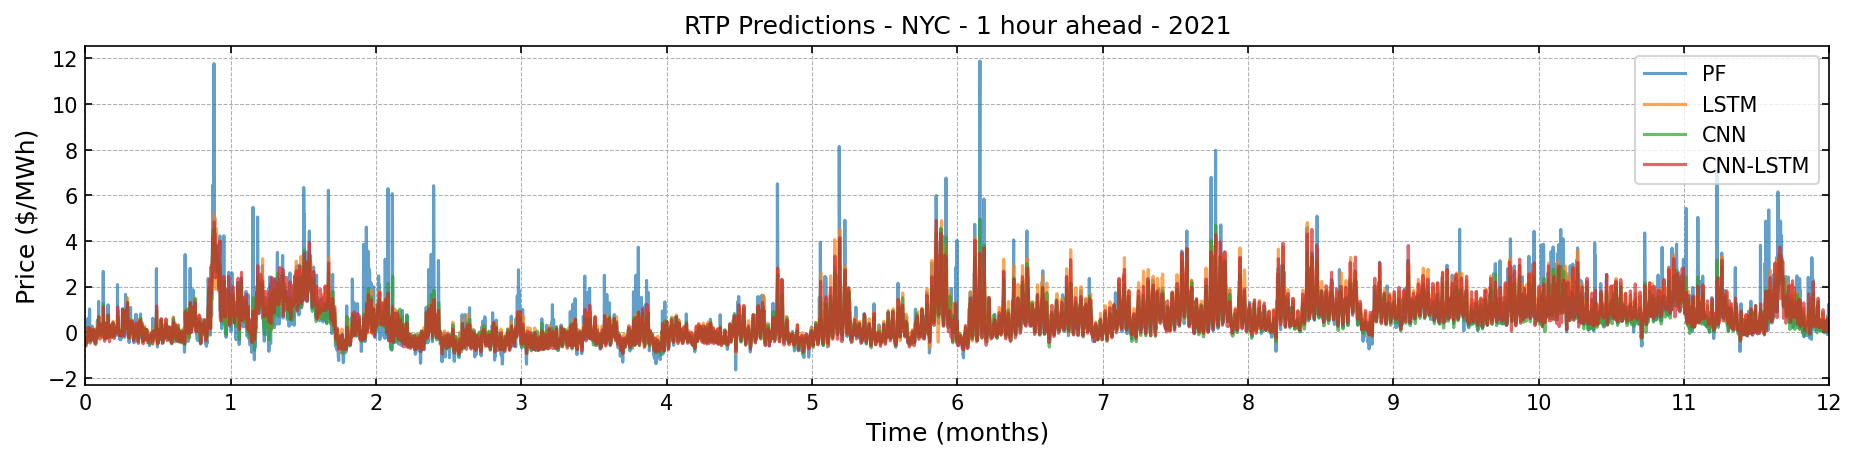

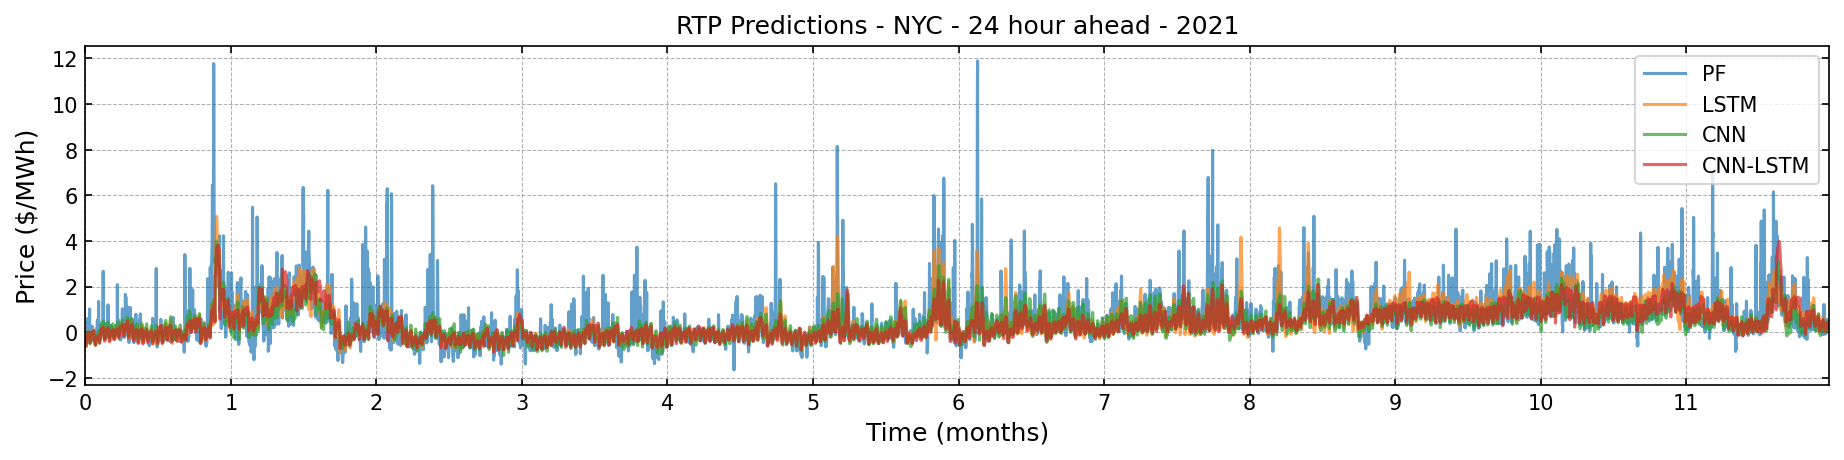

In [40]:
plot_predictions_models(y_test_pred_lstm_24[:,0].flatten(),
                       y_test_pred_cnn_24[:,0].flatten(),
                       y_test_pred_cnn_lstm_24[:,0].flatten(),
                       y_test_lstm_24[:,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - 2021', 'Time (months)',  'hourly_predictions_48_lags_norm',year=True)

plot_predictions_models(y_test_pred_lstm_24[::24,:].flatten(),
                       y_test_pred_cnn_24[::24,:].flatten(),
                       y_test_pred_cnn_lstm_24[::24,:].flatten(),
                       y_test_lstm_24[::24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - 2021', 'Time (months)',  '24ha_predictions_48_lags_norm', year=True)

### lag 72

In [17]:
n_steps_in = 72
n_steps_out = 24
x_test_lstm = np.array([x_test[i:i+n_steps_in] for i in range(0, x_test.shape[0]-n_steps_in-n_steps_out+1)])
y_test_lstm_24 = np.array([y_test[i+n_steps_in:i+n_steps_in+n_steps_out] for i in range(0, y_test.shape[0]-n_steps_in-n_steps_out+1)])

model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

lstm_model = load_model(os.path.join(model_path,'LSTM_model_best_72h.h5'))
y_test_pred_lstm_24 = lstm_model.predict(x_test_lstm)
cnn_model = load_model(os.path.join(model_path,'CNN_model_best_72h.h5'))
y_test_pred_cnn_24 = cnn_model.predict(x_test_lstm)
cnn_lstm_model = load_model(os.path.join(model_path,'CNN_LSTM_model_best_72h.h5'))
y_test_pred_cnn_lstm_24 = cnn_lstm_model.predict(x_test_lstm)

271/271 [==============================] - 1s 2ms/step


In [18]:
y_test_pred_lstm_rescale_24 = y_test_pred_lstm_24*y_std.values + y_mean.values
y_test_lstm_rescale_24 = y_test_lstm_24*y_std.values + y_mean.values
y_test_pred_lstm_invlog_24 = np.exp(y_test_pred_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])
y_test_lstm_invlog_24 = np.exp(y_test_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_rescale_24 = y_test_pred_cnn_24*y_std.values + y_mean.values
y_test_pred_cnn_invlog_24 = np.exp(y_test_pred_cnn_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

y_test_pred_cnn_lstm_rescale_24 = y_test_pred_cnn_lstm_24*y_std.values + y_mean.values
y_test_pred_cnn_lstm_invlog_24 = np.exp(y_test_pred_cnn_lstm_rescale_24) -1 + min(raw_data.loc[:,"RTP"])

LSTM MAE: 11.5954

CNN MAE: 10.9328

CNN-LSTM MAE: 11.6884



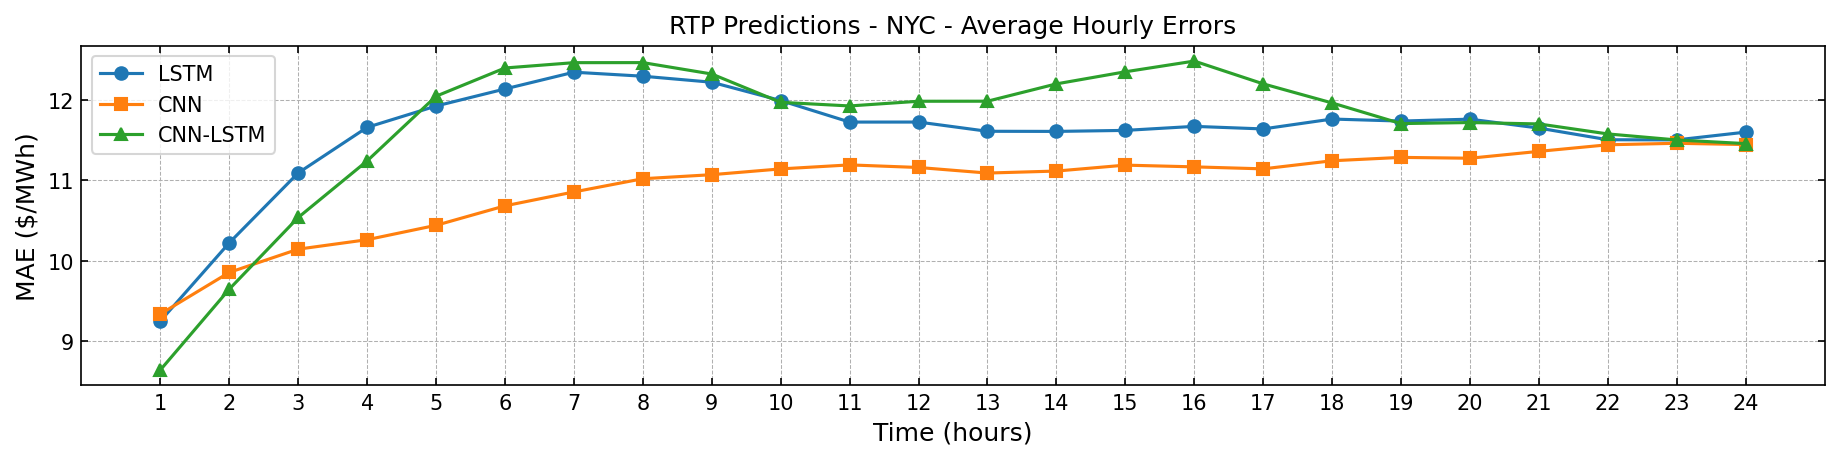

In [19]:
# Evaluation metrics
# 24 hours ahead
# Evaluation metrics
errors_lstm = y_test_pred_lstm_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('LSTM MAE: {:.4f}'.format(np.abs(errors_lstm).mean()))
print('')

errors_cnn = y_test_pred_cnn_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('CNN MAE: {:.4f}'.format(np.abs(errors_cnn).mean()))
print('')

errors_cnn_lstm = y_test_pred_cnn_lstm_invlog_24 - y_test_lstm_invlog_24[:,:,0]
print('CNN-LSTM MAE: {:.4f}'.format(np.abs(errors_cnn_lstm).mean()))
print('')

errors_h_cnn = []
errors_h_cnn_lstm = []
errors_h_lstm = []
for i in range(24):
    # Evaluation metrics for hour ahead only
    errors_h_lstm.append(y_test_pred_lstm_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])
    errors_h_cnn.append(y_test_pred_cnn_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])
    errors_h_cnn_lstm.append(y_test_pred_cnn_lstm_invlog_24[:,i] - y_test_lstm_invlog_24[:,i,0])

plot_hourly_errors(np.abs(errors_h_lstm).mean(axis=1), np.abs(errors_h_cnn).mean(axis=1), np.abs(errors_h_cnn_lstm).mean(axis=1),
                   'RTP Predictions - NYC - Average Hourly Errors', 'hourly_errors_72_lags')

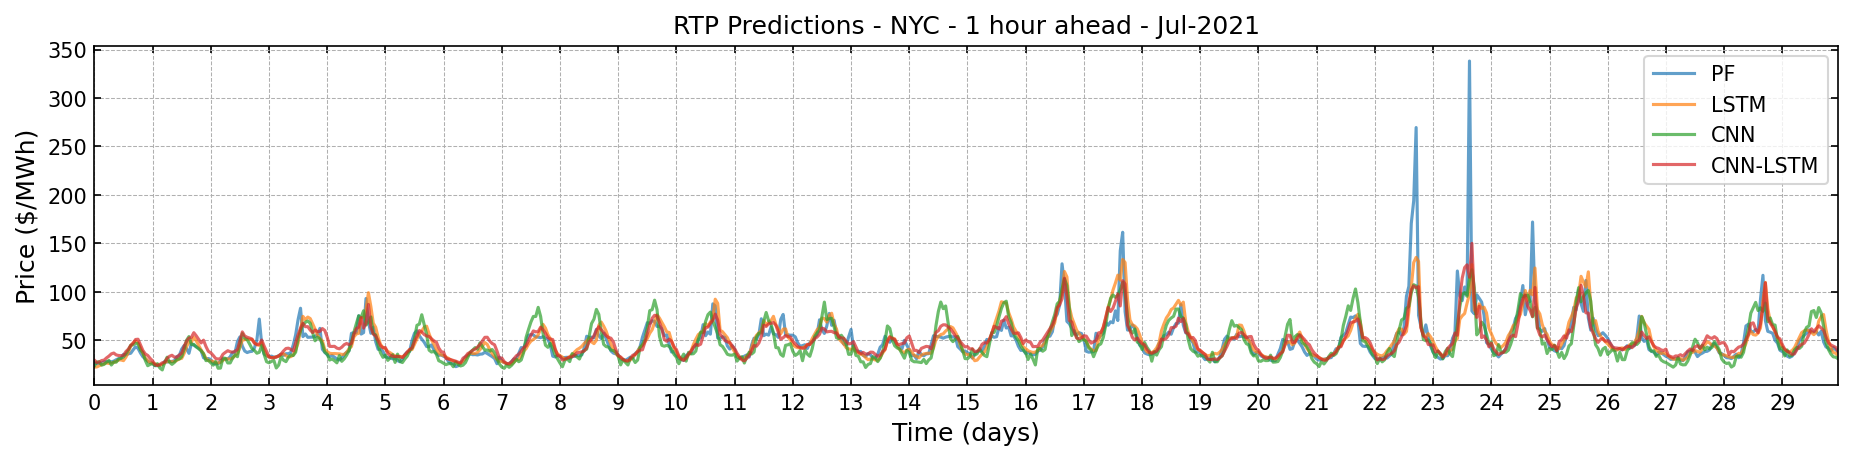

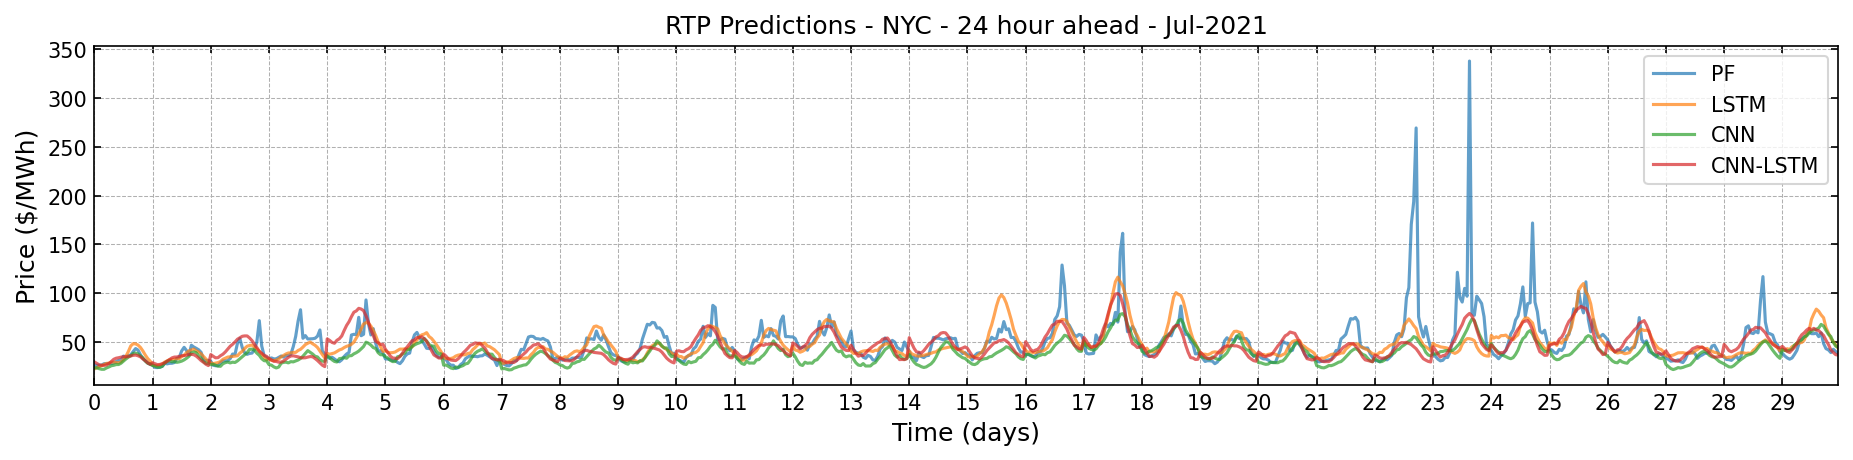

In [33]:
i = 7*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jul-2021', 'Time (days)',  'hourly_predictions_jul_72_lags')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jul-2021', 'Time (days)',  '24ha_predictions_jul_72_lags')

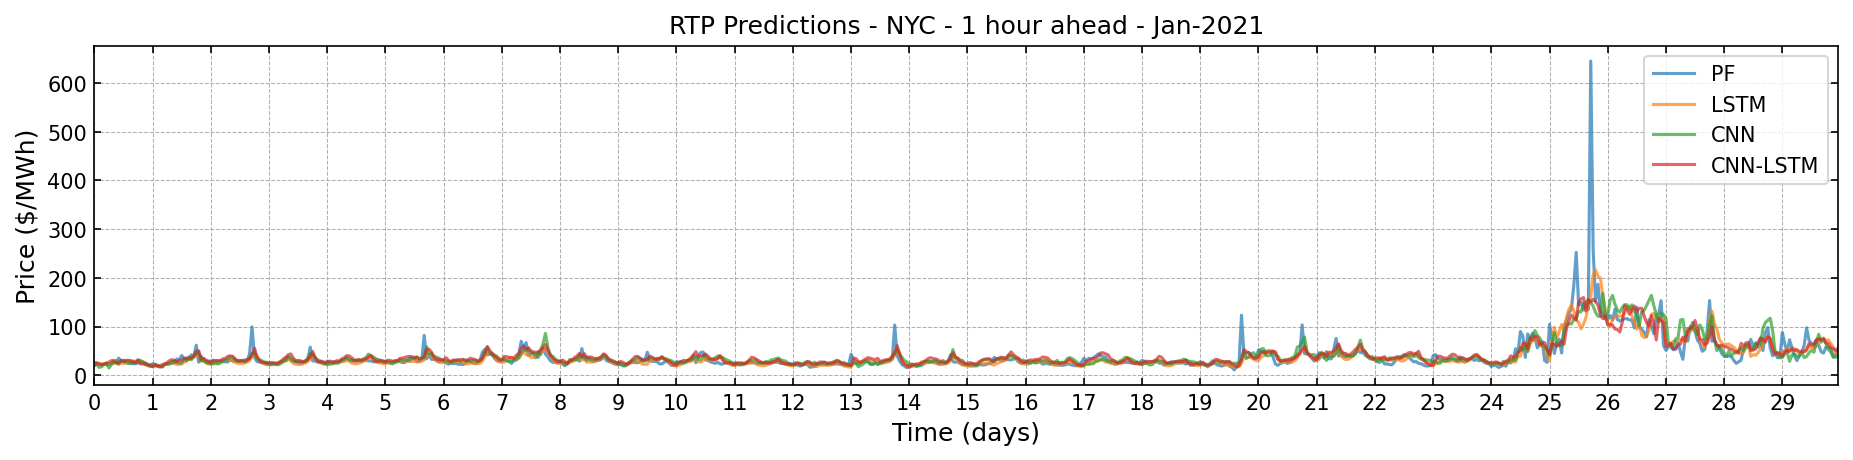

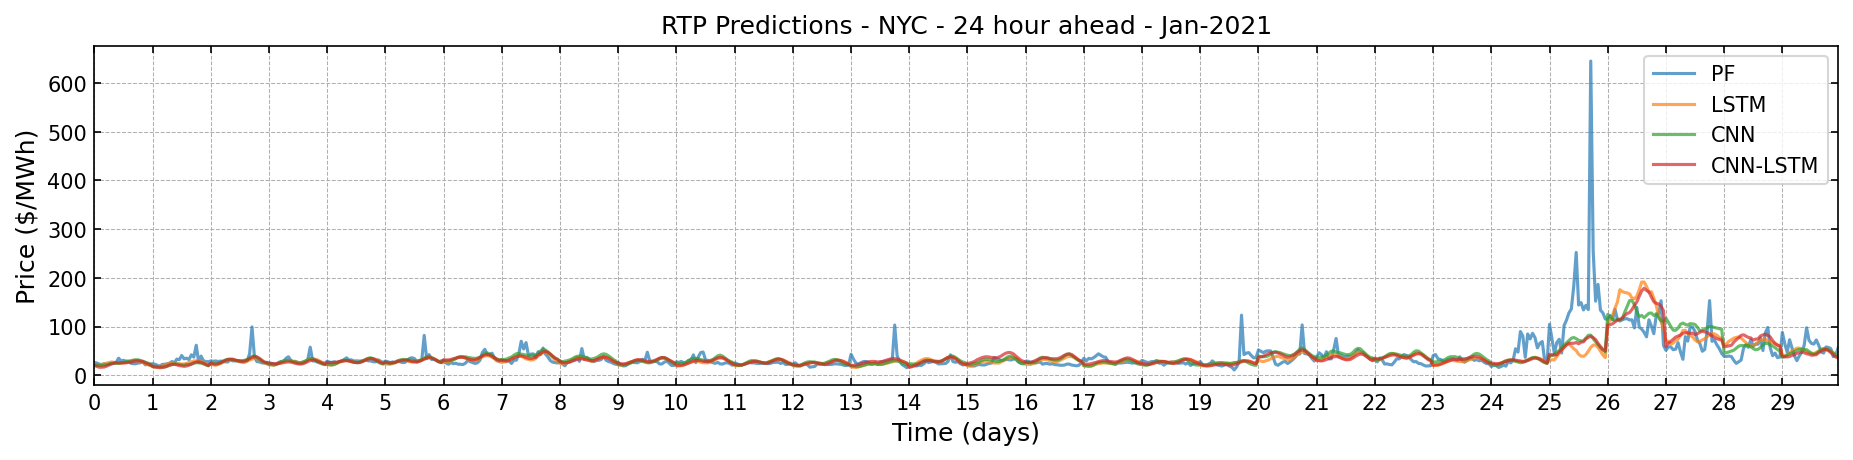

In [34]:
i = 0*24*30
j = i + 24*30

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_invlog_24[i:j,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j,0].flatten(),
                       y_test_lstm_invlog_24[i:j,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - Jan-2021', 'Time (days)',  'hourly_predictions_jan_72_lags')

plot_predictions_models(y_test_pred_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_invlog_24[i:j:24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[i:j:24,:].flatten(),
                       y_test_lstm_invlog_24[i:j:24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - Jan-2021', 'Time (days)',  '24ha_predictions_jan_72_lags')

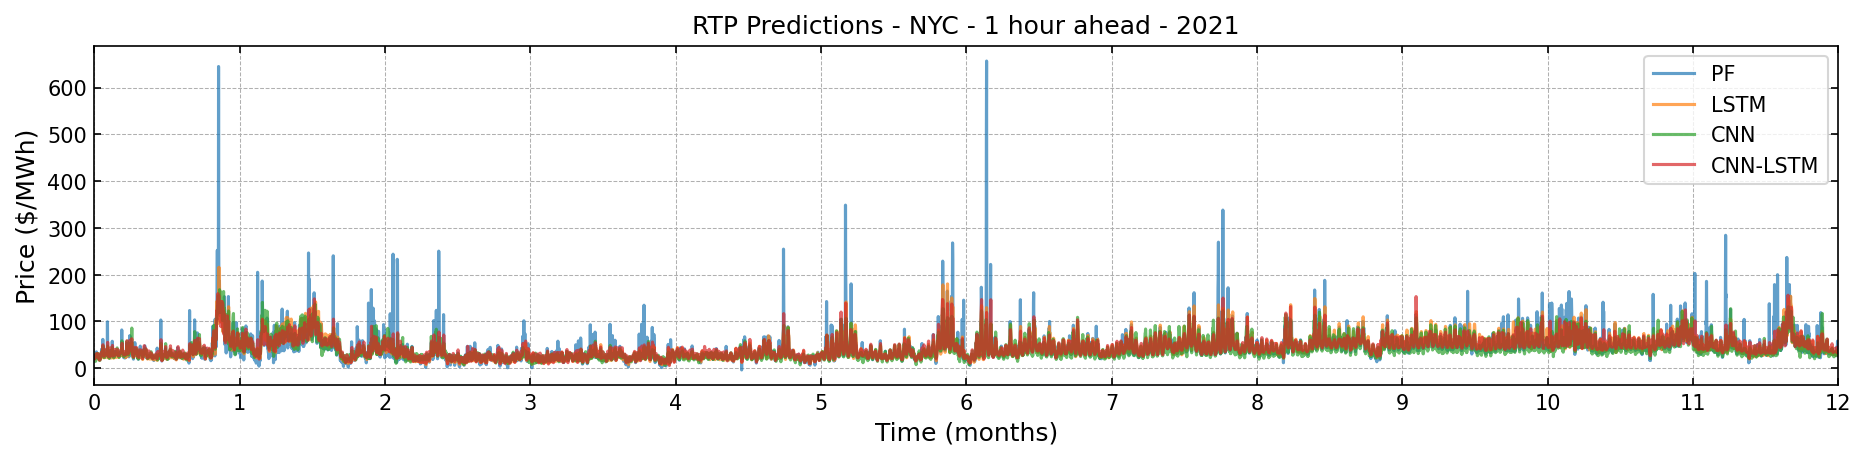

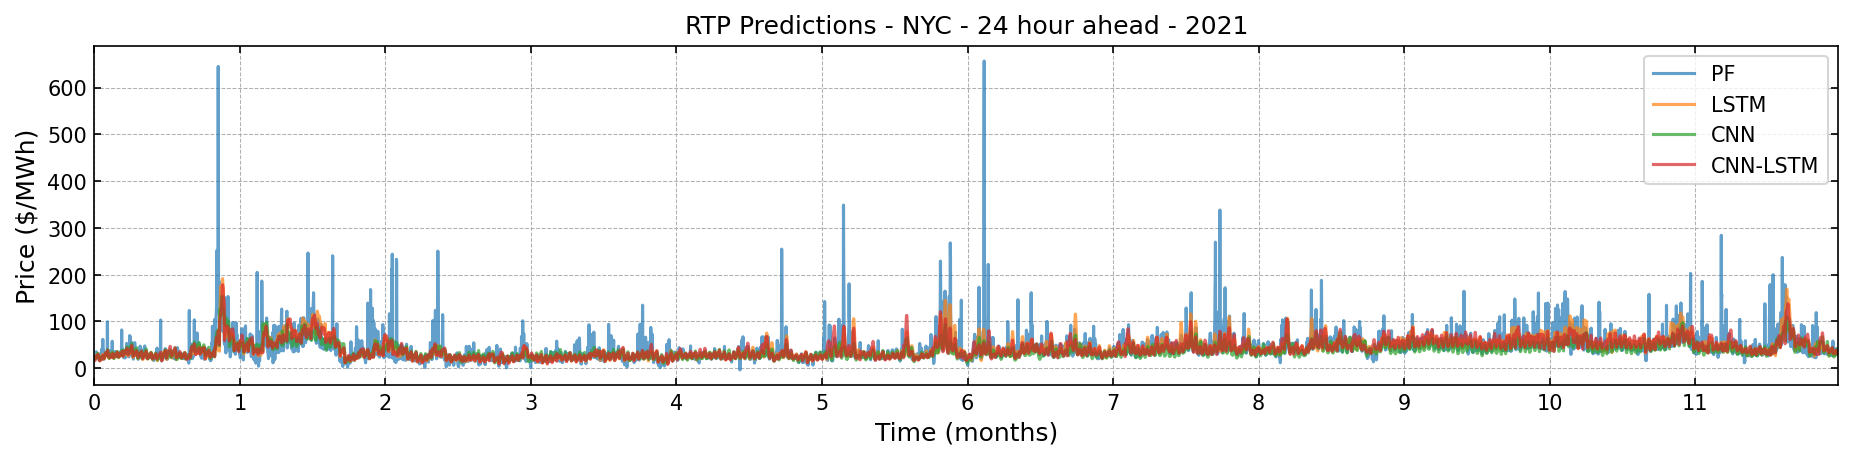

In [35]:
plot_predictions_models(y_test_pred_lstm_invlog_24[:,0].flatten(),
                       y_test_pred_cnn_invlog_24[:,0].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[:,0].flatten(),
                       y_test_lstm_invlog_24[:,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - 2021', 'Time (months)',  'hourly_predictions_72_lags',year=True)

plot_predictions_models(y_test_pred_lstm_invlog_24[::24,:].flatten(),
                       y_test_pred_cnn_invlog_24[::24,:].flatten(),
                       y_test_pred_cnn_lstm_invlog_24[::24,:].flatten(),
                       y_test_lstm_invlog_24[::24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - 2021', 'Time (months)',  '24ha_predictions_72_lags', year=True)

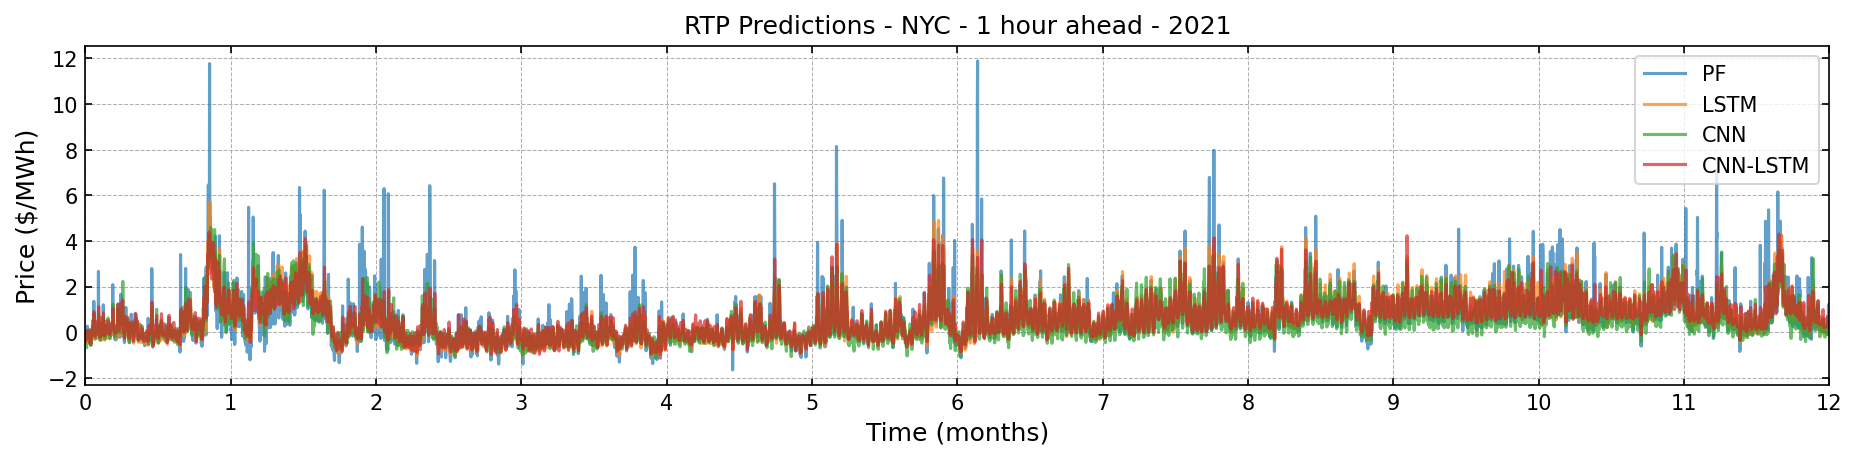

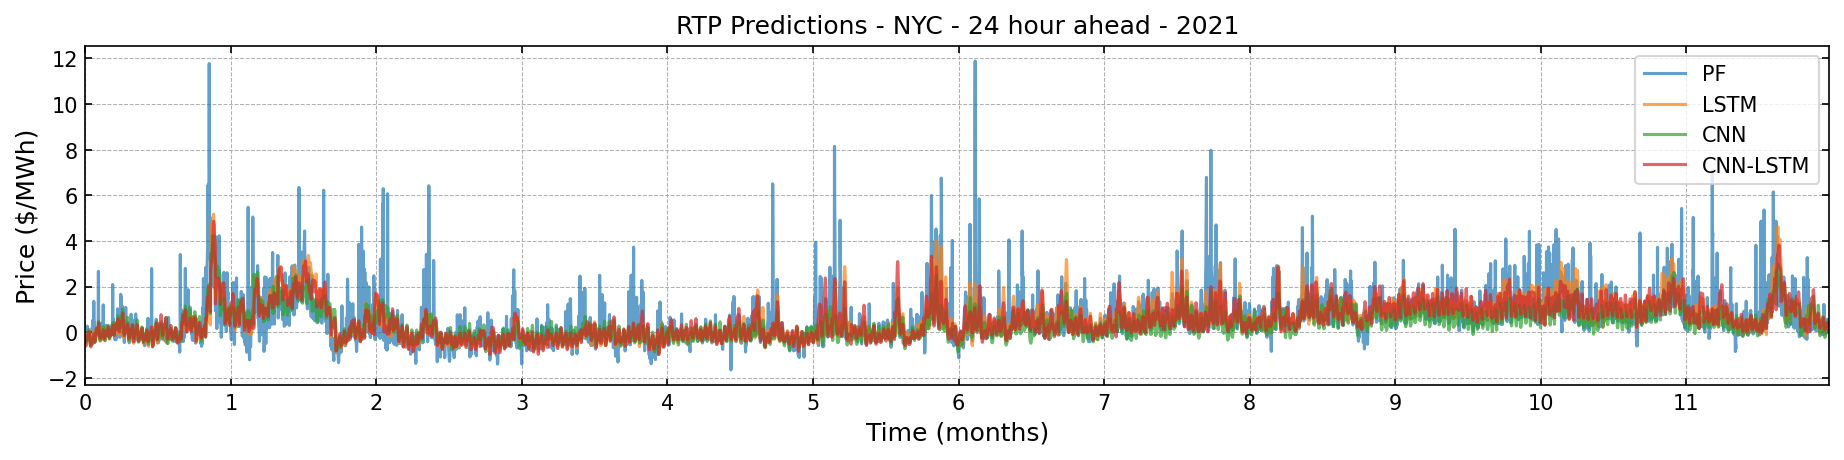

In [36]:
plot_predictions_models(y_test_pred_lstm_24[:,0].flatten(),
                       y_test_pred_cnn_24[:,0].flatten(),
                       y_test_pred_cnn_lstm_24[:,0].flatten(),
                       y_test_lstm_24[:,0,0].flatten(),
                       'RTP Predictions - NYC - 1 hour ahead - 2021', 'Time (months)',  'hourly_predictions_72_lags_norm',year=True)

plot_predictions_models(y_test_pred_lstm_24[::24,:].flatten(),
                       y_test_pred_cnn_24[::24,:].flatten(),
                       y_test_pred_cnn_lstm_24[::24,:].flatten(),
                       y_test_lstm_24[::24,:].flatten(),
                       'RTP Predictions - NYC - 24 hour ahead - 2021', 'Time (months)',  '24ha_predictions_72_lags_norm', year=True)

In [ ]:
# Data
lag_time_steps = [24, 48, 72]
lstm_values = [11.8169, 12.1817, 11.5954]
cnn_values = [10.2440, 10.0895, 10.9328]
cnn_lstm_values = [11.6092, 11.1771, 11.6884]

# Set up bar positions
bar_width = 0.2
bar_positions_lstm = np.arange(len(lag_time_steps))
bar_positions_cnn = bar_positions_lstm + bar_width
bar_positions_cnn_lstm = bar_positions_cnn + bar_width

# Create bar plot
plt.bar(bar_positions_lstm, lstm_values, width=bar_width, label='LSTM')
plt.bar(bar_positions_cnn, cnn_values, width=bar_width, label='CNN')
plt.bar(bar_positions_cnn_lstm, cnn_lstm_values, width=bar_width, label='CNN-LSTM')

# Set axis labels and title
plt.xlabel('Lag Time Steps (slider)')
plt.ylabel('Values')
plt.title('Bar Plot of Lag Time Steps vs. Values for Different Models')

# Set x-axis ticks and labels
plt.xticks(bar_positions_cnn, lag_time_steps)